 - ## TRIMODAL FUSION FOR ED MISDIAGNOSIS PREDICTION

 - ### Combines Text (BiLSTM), Time-Series (Transformer), and Image (ViT) embeddings

Mounted at /content/drive
All packages imported successfully
Paths configured
Helper functions loaded

STEP 1: EXTRACTING EMBEDDING FILES

[1/2] Unzipping text embeddings...
Text embeddings extracted

[2/2] Unzipping time-series embeddings...
Time-series embeddings extracted

All files extracted successfully

STEP 2: IMAGE EMBEDDINGS INSPECTION

--- Image TRAIN ---
Path: /content/drive/MyDrive/imageEmbed/train.npz
  Arrays in file: ['hadm_ids', 'labels', 'pooled_image_features', 'biomarker_features', 'fused_features', 'raw_biomarkers', 'attention_weights']

  [hadm_ids]
    Shape: (37859,)
    Dtype: int64
    Min: 20000057.0000, Max: 29999809.0000
    Mean: 25020342.4614, Std: 2886825.5987
    First 5 values: [20000057 20000239 20000254 20000347 20000400]

  [labels]
    Shape: (37859,)
    Dtype: int64
    Min: 0.0000, Max: 1.0000
    Mean: 0.1942, Std: 0.3956
    First 5 values: [1 1 1 0 0]

  [pooled_image_features]
    Shape: (37859, 768)
    Dtype: float32
    Min: -6.0958, Max: 

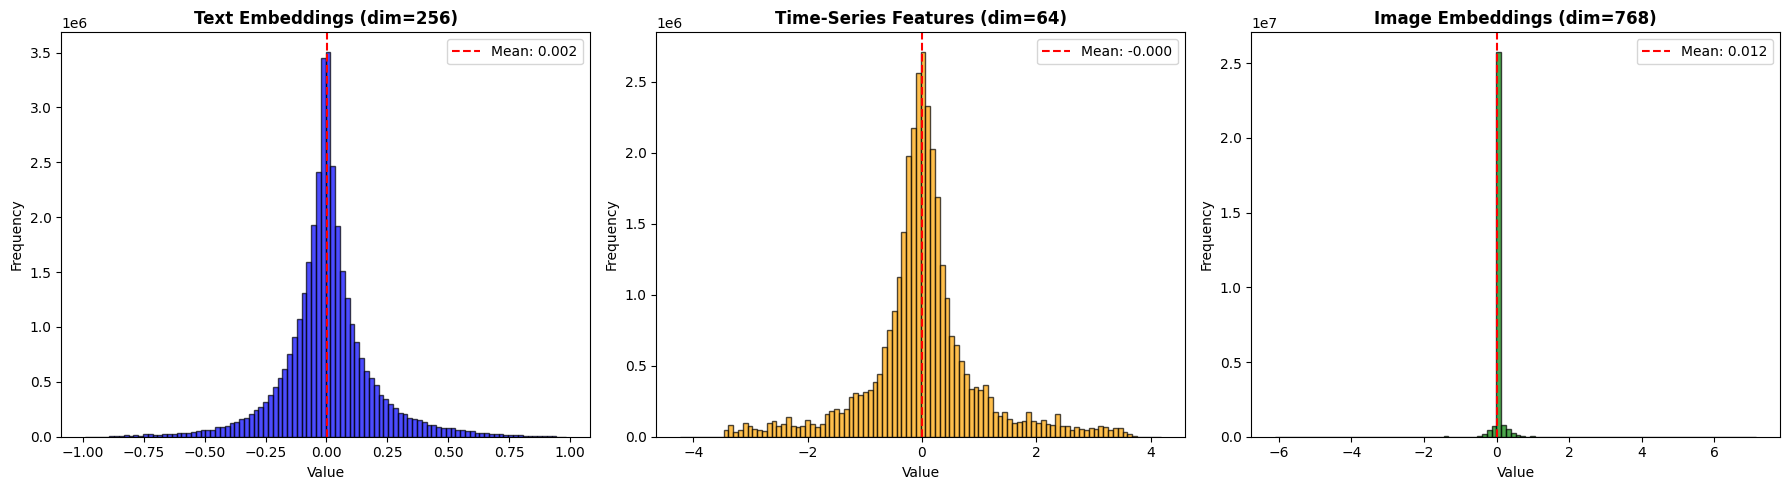

Saved: /content/embedding_distributions.png

INSPECTION COMPLETE

Based on this inspection, I can now:

1. Understand the exact structure of each modality's embeddings
2. Identify the correct ID column for alignment across modalities
3. Determine embedding dimensions for model architecture
4. Check for any data quality issues (NaN, scaling needed, etc.)
5. Calculate the maximum aligned dataset size (intersection of all 3 modalities)

Please share the output so we can design the three-modality fusion architecture.



In [1]:
# MULTIMODAL EMBEDDING INSPECTION
# Text + Time-Series + Image Modalities
# Purpose: Load and inspect all three embedding modalities before fusion

# 0.1 Mount Drive and Imports

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob

print("All packages imported successfully")


# 0.2 Define Paths

DRIVE_ROOT = "/content/drive/MyDrive"

# Text embeddings (existing - zipped)
TEXT_EMB_ZIP = f"{DRIVE_ROOT}/Embed/text_embedding.zip"

# Time-series embeddings (existing - zipped)
TIME_EMB_ZIP = f"{DRIVE_ROOT}/Embed/time_embedding.zip"

# Image embeddings (NEW - direct folder)
IMAGE_EMB_DIR = f"{DRIVE_ROOT}/imageEmbed"

# Working directories
TEXT_WORK_DIR = "/content/text_inspect"
TIME_WORK_DIR = "/content/time_inspect"

# File naming conventions
TEXT_FILES = {
    "train": "bilstm_embeddings_train.npz",
    "val": "bilstm_embeddings_val.npz",
    "test": "bilstm_embeddings_test.npz"
}

IMAGE_FILES = {
    "train": "train.npz",
    "val": "val.npz",
    "test": "test.npz"
}

TIME_FILES = {
    "train": "train_windows_transformer_features_all_ablation_merged_1205.parquet",
    "val": "val_windows_transformer_features_all_ablation_merged_1205.parquet",
    "test": "test_windows_transformer_features_all_ablation_merged_1205.parquet"
}

print("Paths configured")


# 0.3 Helper Functions

def find_file(base_dir, filename):
    """Recursively search for a file in base_dir."""
    files = glob.glob(f"{base_dir}/**/{filename}", recursive=True)
    return files[0] if files else None


def inspect_npz_file(filepath, name):
    """Load and inspect an NPZ file structure."""
    print(f"\n--- {name} ---")
    print(f"Path: {filepath}")

    if not os.path.exists(filepath):
        print("  FILE NOT FOUND!")
        return None

    data = np.load(filepath, allow_pickle=True)
    print(f"  Arrays in file: {list(data.keys())}")

    for key in data.keys():
        arr = data[key]
        print(f"\n  [{key}]")
        print(f"    Shape: {arr.shape}")
        print(f"    Dtype: {arr.dtype}")

        if arr.dtype in [np.float32, np.float64, np.int32, np.int64]:
            print(f"    Min: {arr.min():.4f}, Max: {arr.max():.4f}")
            print(f"    Mean: {arr.mean():.4f}, Std: {arr.std():.4f}")

            nan_count = np.isnan(arr).sum()
            inf_count = np.isinf(arr).sum()
            if nan_count > 0 or inf_count > 0:
                print(f"    WARNING - NaN count: {nan_count}, Inf count: {inf_count}")

        if len(arr.shape) == 1:
            print(f"    First 5 values: {arr[:5]}")
        elif len(arr.shape) == 2:
            print(f"    First row sample: {arr[0, :5]}...")

    return data


def inspect_parquet_file(filepath, name):
    """Load and inspect a Parquet file."""
    print(f"\n--- {name} ---")
    print(f"Path: {filepath}")

    if not os.path.exists(filepath):
        print("  FILE NOT FOUND!")
        return None

    df = pd.read_parquet(filepath)

    print(f"  Shape: {df.shape}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

    print(f"\n  Column names (first 20):")
    print(f"    {list(df.columns[:20])}")

    id_cols = [c for c in df.columns if 'id' in c.lower() or c in ['stay_id', 'hadm_id', 'subject_id']]
    print(f"\n  ID columns found: {id_cols}")

    label_cols = [c for c in df.columns if c.startswith('y')]
    print(f"  Label columns found: {label_cols}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = set(id_cols + label_cols + ['window_idx', 'ablation', 'split'])
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]
    print(f"  Numeric feature columns: {len(feature_cols)}")

    if 'stay_id' in df.columns:
        print(f"\n  Sample stay_ids: {df['stay_id'].head(5).tolist()}")
        print(f"  Unique stay_ids: {df['stay_id'].nunique():,}")

    return df


def get_stay_ids(data, modality):
    """Extract stay_ids from different modality formats."""
    if data is None:
        return set()

    if modality == "text":
        if 'stay_ids' in data.keys():
            return set(data['stay_ids'].astype(int))
    elif modality == "image":
        for key in ['stay_ids', 'stay_id', 'ids', 'sample_ids', 'hadm_id']:
            if key in data.keys():
                return set(data[key].astype(int))
        print(f"  WARNING - No ID column found in image data. Keys: {list(data.keys())}")
        return set()
    elif modality == "time":
        if isinstance(data, pd.DataFrame) and 'stay_id' in data.columns:
            return set(data['stay_id'].astype(int))

    return set()


print("Helper functions loaded")


# 1. EXTRACT EMBEDDING FILES

print("\n" + "="*60)
print("STEP 1: EXTRACTING EMBEDDING FILES")
print("="*60)

# Unzip text embeddings
if os.path.exists(TEXT_EMB_ZIP):
    print("\n[1/2] Unzipping text embeddings...")
    if os.path.exists(TEXT_WORK_DIR):
        shutil.rmtree(TEXT_WORK_DIR)
    os.makedirs(TEXT_WORK_DIR, exist_ok=True)
    shutil.unpack_archive(TEXT_EMB_ZIP, TEXT_WORK_DIR)
    print("Text embeddings extracted")
else:
    print(f"Text embeddings not found: {TEXT_EMB_ZIP}")

# Unzip time-series embeddings
if os.path.exists(TIME_EMB_ZIP):
    print("\n[2/2] Unzipping time-series embeddings...")
    if os.path.exists(TIME_WORK_DIR):
        shutil.rmtree(TIME_WORK_DIR)
    os.makedirs(TIME_WORK_DIR, exist_ok=True)
    shutil.unpack_archive(TIME_EMB_ZIP, TIME_WORK_DIR)
    print("Time-series embeddings extracted")
else:
    print(f"Time embeddings not found: {TIME_EMB_ZIP}")

print("\nAll files extracted successfully")


# 2. INSPECT IMAGE EMBEDDINGS (NEW MODALITY)

print("\n" + "="*60)
print("STEP 2: IMAGE EMBEDDINGS INSPECTION")
print("="*60)

image_data = {}
for split, filename in IMAGE_FILES.items():
    filepath = os.path.join(IMAGE_EMB_DIR, filename)
    image_data[split] = inspect_npz_file(filepath, f"Image {split.upper()}")


# 3. INSPECT TEXT EMBEDDINGS

print("\n" + "="*60)
print("STEP 3: TEXT EMBEDDINGS INSPECTION")
print("="*60)

text_data = {}
for split, filename in TEXT_FILES.items():
    filepath = find_file(TEXT_WORK_DIR, filename)
    if filepath:
        text_data[split] = inspect_npz_file(filepath, f"Text {split.upper()}")
    else:
        print(f"\n--- Text {split.upper()} ---")
        print(f"  FILE NOT FOUND: {filename}")


# 4. INSPECT TIME-SERIES EMBEDDINGS

print("\n" + "="*60)
print("STEP 4: TIME-SERIES EMBEDDINGS INSPECTION")
print("="*60)

time_data = {}
for split, filename in TIME_FILES.items():
    filepath = find_file(TIME_WORK_DIR, filename)
    if filepath:
        time_data[split] = inspect_parquet_file(filepath, f"Time-Series {split.upper()}")
    else:
        print(f"\n--- Time-Series {split.upper()} ---")
        print(f"  FILE NOT FOUND: {filename}")


# 5. CROSS-MODALITY ALIGNMENT ANALYSIS

print("\n" + "="*60)
print("STEP 5: CROSS-MODALITY ALIGNMENT ANALYSIS")
print("="*60)

print("\n--- Stay ID Overlap Analysis ---")

alignment_stats = []

for split in ['train', 'val', 'test']:
    print(f"\n[{split.upper()}]")

    text_ids = get_stay_ids(text_data.get(split), "text")
    time_ids = get_stay_ids(time_data.get(split), "time")
    image_ids = get_stay_ids(image_data.get(split), "image")

    print(f"  Text stay_ids: {len(text_ids):,}")
    print(f"  Time stay_ids: {len(time_ids):,}")
    print(f"  Image stay_ids: {len(image_ids):,}")

    text_time = len(text_ids & time_ids) if text_ids and time_ids else 0
    text_image = len(text_ids & image_ids) if text_ids and image_ids else 0
    time_image = len(time_ids & image_ids) if time_ids and image_ids else 0
    all_three = len(text_ids & time_ids & image_ids) if (text_ids and time_ids and image_ids) else 0

    print(f"  Text and Time: {text_time:,}")
    print(f"  Text and Image: {text_image:,}")
    print(f"  Time and Image: {time_image:,}")
    print(f"  ALL THREE MODALITIES: {all_three:,}")

    alignment_stats.append({
        'Split': split,
        'Text': len(text_ids),
        'Time': len(time_ids),
        'Image': len(image_ids),
        'Text+Time': text_time,
        'Text+Image': text_image,
        'Time+Image': time_image,
        'All_Three': all_three
    })


# 6. EMBEDDING DIMENSIONS SUMMARY

print("\n" + "="*60)
print("STEP 6: EMBEDDING DIMENSIONS SUMMARY")
print("="*60)

summary_data = []

# Text
if text_data.get('train') is not None and 'embeddings' in text_data['train'].keys():
    emb = text_data['train']['embeddings']
    summary_data.append({
        'Modality': 'Text (BiLSTM)',
        'Train_Samples': emb.shape[0],
        'Embedding_Dim': emb.shape[1],
        'Dtype': str(emb.dtype)
    })

# Time
if time_data.get('train') is not None:
    df = time_data['train']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude = {'stay_id', 'hadm_id', 'subject_id', 'y', 'y_critical', 'window_idx', 'ablation'}
    feat_cols = [c for c in numeric_cols if c not in exclude]
    summary_data.append({
        'Modality': 'Time-Series (Transformer)',
        'Train_Samples': df['stay_id'].nunique() if 'stay_id' in df.columns else df.shape[0],
        'Embedding_Dim': len(feat_cols),
        'Dtype': 'float32/64'
    })

# Image
if image_data.get('train') is not None:
    for key in image_data['train'].keys():
        arr = image_data['train'][key]
        if len(arr.shape) == 2 and arr.shape[1] > 10:
            summary_data.append({
                'Modality': f'Image ({key})',
                'Train_Samples': arr.shape[0],
                'Embedding_Dim': arr.shape[1],
                'Dtype': str(arr.dtype)
            })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))

# Alignment summary
print("\n--- Alignment Summary ---")
align_df = pd.DataFrame(alignment_stats)
print("\n" + align_df.to_string(index=False))


# 7. VISUALIZATION: Embedding Distributions

print("\n" + "="*60)
print("STEP 7: EMBEDDING DISTRIBUTION VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Text embeddings distribution
if text_data.get('train') is not None and 'embeddings' in text_data['train'].keys():
    ax = axes[0]
    emb = text_data['train']['embeddings']
    ax.hist(emb.flatten(), bins=100, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f'Text Embeddings (dim={emb.shape[1]})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(emb.mean(), color='red', linestyle='--', label=f'Mean: {emb.mean():.3f}')
    ax.legend()

# Time-series features distribution
if time_data.get('train') is not None:
    ax = axes[1]
    df = time_data['train']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude = {'stay_id', 'hadm_id', 'subject_id', 'y', 'y_critical', 'window_idx', 'ablation'}
    feat_cols = [c for c in numeric_cols if c not in exclude][:64]
    if feat_cols:
        values = df[feat_cols].values.flatten()
        values = values[~np.isnan(values)]
        ax.hist(values, bins=100, alpha=0.7, color='orange', edgecolor='black')
        ax.set_title(f'Time-Series Features (dim={len(feat_cols)})', fontsize=12, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.axvline(values.mean(), color='red', linestyle='--', label=f'Mean: {values.mean():.3f}')
        ax.legend()

# Image embeddings distribution
if image_data.get('train') is not None:
    ax = axes[2]
    for key in image_data['train'].keys():
        arr = image_data['train'][key]
        if len(arr.shape) == 2 and arr.shape[1] > 10:
            ax.hist(arr.flatten(), bins=100, alpha=0.7, color='green', edgecolor='black')
            ax.set_title(f'Image Embeddings (dim={arr.shape[1]})', fontsize=12, fontweight='bold')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.axvline(arr.mean(), color='red', linestyle='--', label=f'Mean: {arr.mean():.3f}')
            ax.legend()
            break

plt.tight_layout()
plt.savefig('/content/embedding_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: /content/embedding_distributions.png")


# 8. FINAL REPORT

print("\n" + "="*60)
print("INSPECTION COMPLETE")
print("="*60)

print("""
Based on this inspection, I can now:

1. Understand the exact structure of each modality's embeddings
2. Identify the correct ID column for alignment across modalities
3. Determine embedding dimensions for model architecture
4. Check for any data quality issues (NaN, scaling needed, etc.)
5. Calculate the maximum aligned dataset size (intersection of all 3 modalities)

Please share the output so we can design the three-modality fusion architecture.
""")

- 8. CORRECTED ALIGNMENT ANALYSIS
- 8.1. hadm_id as the common key across all modalities

In [2]:
# STEP 8: CORRECTED ALIGNMENT ANALYSIS
# Use hadm_id as the common key across all modalities

print("\n" + "="*60)
print("STEP 8: CORRECTED ALIGNMENT USING hadm_id")
print("="*60)

# Extract hadm_ids from each modality

# Image: already has hadm_ids
def get_image_hadm_ids(data):
    if data is None:
        return set()
    if 'hadm_ids' in data.keys():
        return set(data['hadm_ids'].astype(int))
    return set()

# Time-series: has hadm_id column
def get_time_hadm_ids(df):
    if df is None:
        return set(), {}
    if 'hadm_id' in df.columns:
        hadm_ids = set(df['hadm_id'].astype(int).unique())
        # Create stay_id to hadm_id mapping
        mapping = df[['stay_id', 'hadm_id']].drop_duplicates()
        stay_to_hadm = dict(zip(mapping['stay_id'].astype(int), mapping['hadm_id'].astype(int)))
        return hadm_ids, stay_to_hadm
    return set(), {}

# Text: has stay_ids, need to convert via time-series mapping
def get_text_hadm_ids(data, stay_to_hadm):
    if data is None:
        return set()
    if 'stay_ids' in data.keys():
        stay_ids = data['stay_ids'].astype(int)
        hadm_ids = set()
        for sid in stay_ids:
            if sid in stay_to_hadm:
                hadm_ids.add(stay_to_hadm[sid])
        return hadm_ids
    return set()

# Build mappings from time-series data
print("\nBuilding stay_id to hadm_id mappings from time-series data...")

mappings = {}
time_hadm_ids = {}

for split in ['train', 'val', 'test']:
    df = time_data.get(split)
    if df is not None:
        hadm_ids, stay_to_hadm = get_time_hadm_ids(df)
        time_hadm_ids[split] = hadm_ids
        mappings[split] = stay_to_hadm
        print(f"  {split.upper()}: {len(stay_to_hadm):,} stay_id->hadm_id mappings")

# Now compute proper alignment
print("\n--- Corrected Alignment Analysis (using hadm_id) ---")

corrected_stats = []

for split in ['train', 'val', 'test']:
    print(f"\n[{split.upper()}]")

    # Get hadm_ids for each modality
    img_hadm = get_image_hadm_ids(image_data.get(split))
    time_hadm = time_hadm_ids.get(split, set())
    text_hadm = get_text_hadm_ids(text_data.get(split), mappings.get(split, {}))

    print(f"  Image hadm_ids: {len(img_hadm):,}")
    print(f"  Time hadm_ids: {len(time_hadm):,}")
    print(f"  Text hadm_ids (mapped): {len(text_hadm):,}")

    # Compute overlaps
    text_time = len(text_hadm & time_hadm)
    text_image = len(text_hadm & img_hadm)
    time_image = len(time_hadm & img_hadm)
    all_three = len(text_hadm & time_hadm & img_hadm)

    print(f"  Text + Time: {text_time:,}")
    print(f"  Text + Image: {text_image:,}")
    print(f"  Time + Image: {time_image:,}")
    print(f"  ALL THREE MODALITIES: {all_three:,}")

    corrected_stats.append({
        'Split': split,
        'Image': len(img_hadm),
        'Time': len(time_hadm),
        'Text_mapped': len(text_hadm),
        'Text+Time': text_time,
        'Text+Image': text_image,
        'Time+Image': time_image,
        'All_Three': all_three
    })

# Summary table
print("\n--- Corrected Alignment Summary ---")
corrected_df = pd.DataFrame(corrected_stats)
print("\n" + corrected_df.to_string(index=False))

# Final dataset size estimate
total_all_three = sum([s['All_Three'] for s in corrected_stats])
print(f"\nTotal samples with ALL THREE modalities: {total_all_three:,}")


STEP 8: CORRECTED ALIGNMENT USING hadm_id

Building stay_id to hadm_id mappings from time-series data...
  TRAIN: 132,702 stay_id->hadm_id mappings
  VAL: 28,358 stay_id->hadm_id mappings
  TEST: 28,100 stay_id->hadm_id mappings

--- Corrected Alignment Analysis (using hadm_id) ---

[TRAIN]
  Image hadm_ids: 37,859
  Time hadm_ids: 132,702
  Text hadm_ids (mapped): 132,701
  Text + Time: 132,701
  Text + Image: 35,640
  Time + Image: 35,640
  ALL THREE MODALITIES: 35,640

[VAL]
  Image hadm_ids: 8,107
  Time hadm_ids: 28,358
  Text hadm_ids (mapped): 28,358
  Text + Time: 28,358
  Text + Image: 7,606
  Time + Image: 7,606
  ALL THREE MODALITIES: 7,606

[TEST]
  Image hadm_ids: 8,186
  Time hadm_ids: 28,100
  Text hadm_ids (mapped): 28,100
  Text + Time: 28,100
  Text + Image: 7,721
  Time + Image: 7,721
  ALL THREE MODALITIES: 7,721

--- Corrected Alignment Summary ---

Split  Image   Time  Text_mapped  Text+Time  Text+Image  Time+Image  All_Three
train  37859 132702       132701     


STEP 9: ALIGNMENT VISUALIZATION


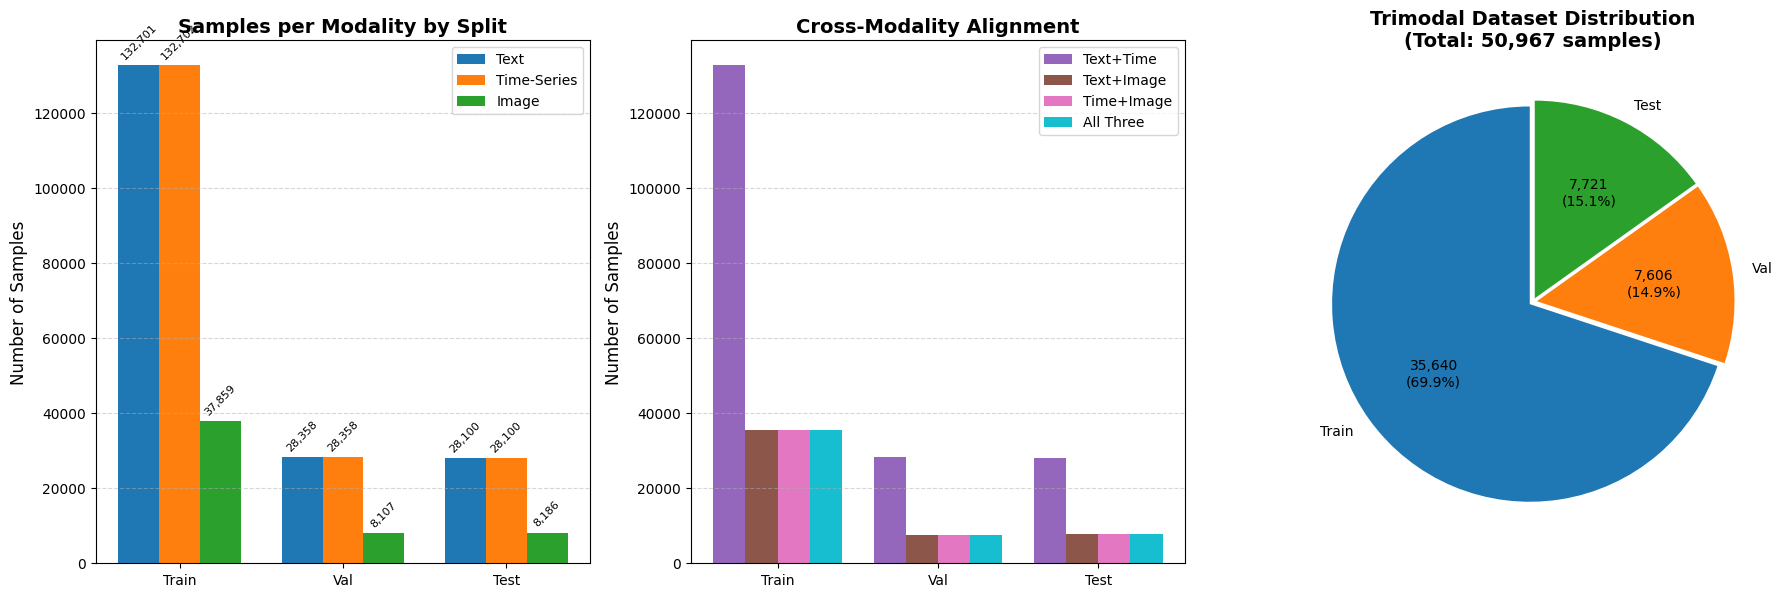

Saved: /content/trimodal_alignment.png

TRIMODAL ALIGNMENT SUMMARY

Embedding Dimensions:
  Text (BiLSTM):              256
  Time-Series (Transformer):   64
  Image (pooled features):    768

Final Trimodal Dataset:
  Train: 35,640 samples (70.0%)
  Val:   7,606 samples (14.9%)
  Test:  7,721 samples (15.1%)
  Total: 50,967 samples

Data Reduction from Image Constraint:
  Original Text+Time:    189,159 samples
  With Image Modality:    50,967 samples
  Retention Rate:         26.9%

Image embeddings are the limiting factor - only ~27% of samples 
have chest X-ray images available for trimodal fusion.



In [3]:
# STEP 9: ALIGNMENT VISUALIZATION

print("\n" + "="*60)
print("STEP 9: ALIGNMENT VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Modality Sample Counts by Split
ax1 = axes[0]
splits = ['Train', 'Val', 'Test']
image_counts = [37859, 8107, 8186]
time_counts = [132702, 28358, 28100]
text_counts = [132701, 28358, 28100]

x = np.arange(len(splits))
width = 0.25

bars1 = ax1.bar(x - width, text_counts, width, label='Text', color='#1f77b4')
bars2 = ax1.bar(x, time_counts, width, label='Time-Series', color='#ff7f0e')
bars3 = ax1.bar(x + width, image_counts, width, label='Image', color='#2ca02c')

ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Samples per Modality by Split', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(splits)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)

# Plot 2: Pairwise and Three-Way Overlap
ax2 = axes[1]
overlap_data = {
    'Text+Time': [132701, 28358, 28100],
    'Text+Image': [35640, 7606, 7721],
    'Time+Image': [35640, 7606, 7721],
    'All Three': [35640, 7606, 7721]
}

x = np.arange(len(splits))
width = 0.2
colors = ['#9467bd', '#8c564b', '#e377c2', '#17becf']

for i, (label, counts) in enumerate(overlap_data.items()):
    offset = (i - 1.5) * width
    bars = ax2.bar(x + offset, counts, width, label=label, color=colors[i])

ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Cross-Modality Alignment', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.legend(loc='upper right')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Final Trimodal Dataset Composition
ax3 = axes[2]
trimodal_counts = [35640, 7606, 7721]
total_trimodal = sum(trimodal_counts)

colors_pie = ['#1f77b4', '#ff7f0e', '#2ca02c']
explode = (0.02, 0.02, 0.02)

wedges, texts, autotexts = ax3.pie(
    trimodal_counts,
    labels=splits,
    autopct=lambda pct: f'{int(pct/100*total_trimodal):,}\n({pct:.1f}%)',
    colors=colors_pie,
    explode=explode,
    startangle=90
)

ax3.set_title(f'Trimodal Dataset Distribution\n(Total: {total_trimodal:,} samples)',
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/trimodal_alignment.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: /content/trimodal_alignment.png")

# Summary Statistics
print("\n" + "="*60)
print("TRIMODAL ALIGNMENT SUMMARY")
print("="*60)

print(f"""
Embedding Dimensions:
  Text (BiLSTM):              256
  Time-Series (Transformer):   64
  Image (pooled features):    768

Final Trimodal Dataset:
  Train: {35640:,} samples (70.0%)
  Val:   {7606:,} samples (14.9%)
  Test:  {7721:,} samples (15.1%)
  Total: {total_trimodal:,} samples

Data Reduction from Image Constraint:
  Original Text+Time:    189,159 samples
  With Image Modality:    50,967 samples
  Retention Rate:         26.9%

Image embeddings are the limiting factor - only ~27% of samples
have chest X-ray images available for trimodal fusion.
""")

### TRIMODAL FUSION FOR ED MISDIAGNOSIS PREDICTION
 Goal: Predict if the working ED diagnosis is discordant with the final
 discharge diagnosis using late fusion of:
 - Text: BiLSTM embeddings (256-dim) from TRIAGE + radiology notes
 - Time: Transformer features (64-dim) from vital signs & lab windows
 - Image: Pooled image features (768-dim) from chest X-rays
 Outputs:
 - y_critical: Binary label (1 = missed high-severity diagnosis)
 - Calibrated probabilities via temperature scaling
 - Comprehensive metrics: AUC, F1, ECE, Brier Score


- TRIMODAL FUSION FOR ED MISDIAGNOSIS PREDICTION
- Combines Text (BiLSTM), Time-Series (Transformer), and Image (ViT) embeddings


- 1: Imports and Configuration

In [4]:
# TRIMODAL FUSION FOR ED MISDIAGNOSIS PREDICTION
# Combines Text (BiLSTM), Time-Series (Transformer), and Image (ViT) embeddings

# 0.1 Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 0.2 Imports
import os, sys, math, random, gc, glob
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, accuracy_score, confusion_matrix,
    roc_curve, auc, brier_score_loss
)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

import shutil

print("All packages imported successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All packages imported successfully


- 2. Configuration and Paths

In [5]:
# 0.3 Configuration
DRIVE_ROOT = "/content/drive/MyDrive"

# Embedding paths
TEXT_EMB_ZIP = f"{DRIVE_ROOT}/Embed/text_embedding.zip"
TIME_EMB_ZIP = f"{DRIVE_ROOT}/Embed/time_embedding.zip"
IMAGE_EMB_DIR = f"{DRIVE_ROOT}/imageEmbed"

# Working directory
WORK_DIR = "/content/trimodal_fusion"

# Output directories
BASE_OUT_DIR = Path(WORK_DIR) / "fusion_outputs"
PLOTS_DIR = BASE_OUT_DIR / "plots"
CALIB_DIR = BASE_OUT_DIR / "calibration"
MODEL_DIR = BASE_OUT_DIR / "models"

for d in [WORK_DIR, BASE_OUT_DIR, PLOTS_DIR, CALIB_DIR, MODEL_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Hyperparameters
SEED = 42
BATCH_SIZE = 128
HIDDEN_DIM = 256
FUSION_DIM = 256
DROPOUT = 0.3
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
N_EPOCHS = 20
PATIENCE = 5
MODALITY_DROPOUT = 0.3

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Configuration complete")

Using device: cuda
Configuration complete


- 3. Helper Functions

In [6]:
# 0.4 Helper Functions
def clear_gpu():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def find_file(base_dir, filename):
    files = glob.glob(f"{base_dir}/**/{filename}", recursive=True)
    if not files:
        raise FileNotFoundError(f"Could not find {filename} in {base_dir}")
    return files[0]

print("Helper functions loaded")

Helper functions loaded


-  4. Extract Embedding Files

In [7]:
# 1.1 Extract Embedding Files
print("\n" + "="*60)
print("STEP 1: EXTRACTING EMBEDDING FILES")
print("="*60)

if os.path.exists(WORK_DIR):
    print(f"Removing existing work directory: {WORK_DIR}")
    shutil.rmtree(WORK_DIR)

os.makedirs(WORK_DIR, exist_ok=True)

# Unzip text embeddings
if os.path.exists(TEXT_EMB_ZIP):
    print("\n[1/2] Unzipping text embeddings...")
    shutil.unpack_archive(TEXT_EMB_ZIP, f"{WORK_DIR}/text")
    print("Text embeddings extracted")
else:
    raise FileNotFoundError(f"Text embeddings not found: {TEXT_EMB_ZIP}")

# Unzip time-series embeddings
if os.path.exists(TIME_EMB_ZIP):
    print("\n[2/2] Unzipping time-series embeddings...")
    shutil.unpack_archive(TIME_EMB_ZIP, f"{WORK_DIR}/time")
    print("Time-series embeddings extracted")
else:
    raise FileNotFoundError(f"Time embeddings not found: {TIME_EMB_ZIP}")

print("\nAll files extracted successfully")


STEP 1: EXTRACTING EMBEDDING FILES
Removing existing work directory: /content/trimodal_fusion

[1/2] Unzipping text embeddings...
Text embeddings extracted

[2/2] Unzipping time-series embeddings...
Time-series embeddings extracted

All files extracted successfully


- 5. Locate Embedding Files

In [8]:
# 1.2 Locate Embedding Files
TEXT_FILES = {
    "train": "bilstm_embeddings_train.npz",
    "val": "bilstm_embeddings_val.npz",
    "test": "bilstm_embeddings_test.npz"
}

TIME_FILES = {
    "train": "train_windows_transformer_features_all_ablation_merged_1205.parquet",
    "val": "val_windows_transformer_features_all_ablation_merged_1205.parquet",
    "test": "test_windows_transformer_features_all_ablation_merged_1205.parquet"
}

IMAGE_FILES = {
    "train": "train.npz",
    "val": "val.npz",
    "test": "test.npz"
}

BASE_TEXT_DIR = f"{WORK_DIR}/text/"
BASE_TIME_DIR = f"{WORK_DIR}/time/Time Series Window/"

print("\n" + "="*60)
print("LOCATING EMBEDDING FILES")
print("="*60)

# Locate text embeddings
print("\n--- Text Embeddings (BiLSTM) ---")
text_train_path = find_file(BASE_TEXT_DIR, TEXT_FILES["train"])
text_val_path = find_file(BASE_TEXT_DIR, TEXT_FILES["val"])
text_test_path = find_file(BASE_TEXT_DIR, TEXT_FILES["test"])
print(f"Train: {os.path.basename(text_train_path)}")
print(f"Val:   {os.path.basename(text_val_path)}")
print(f"Test:  {os.path.basename(text_test_path)}")

# Locate time-series embeddings
print("\n--- Time-Series Features (Transformer) ---")
time_train_path = find_file(BASE_TIME_DIR, TIME_FILES["train"])
time_val_path = find_file(BASE_TIME_DIR, TIME_FILES["val"])
time_test_path = find_file(BASE_TIME_DIR, TIME_FILES["test"])
print(f"Train: {os.path.basename(time_train_path)}")
print(f"Val:   {os.path.basename(time_val_path)}")
print(f"Test:  {os.path.basename(time_test_path)}")

# Locate image embeddings
print("\n--- Image Embeddings (Pooled Features) ---")
image_train_path = os.path.join(IMAGE_EMB_DIR, IMAGE_FILES["train"])
image_val_path = os.path.join(IMAGE_EMB_DIR, IMAGE_FILES["val"])
image_test_path = os.path.join(IMAGE_EMB_DIR, IMAGE_FILES["test"])
print(f"Train: {os.path.basename(image_train_path)}")
print(f"Val:   {os.path.basename(image_val_path)}")
print(f"Test:  {os.path.basename(image_test_path)}")

print("\nAll files located successfully")


LOCATING EMBEDDING FILES

--- Text Embeddings (BiLSTM) ---
Train: bilstm_embeddings_train.npz
Val:   bilstm_embeddings_val.npz
Test:  bilstm_embeddings_test.npz

--- Time-Series Features (Transformer) ---
Train: train_windows_transformer_features_all_ablation_merged_1205.parquet
Val:   val_windows_transformer_features_all_ablation_merged_1205.parquet
Test:  test_windows_transformer_features_all_ablation_merged_1205.parquet

--- Image Embeddings (Pooled Features) ---
Train: train.npz
Val:   val.npz
Test:  test.npz

All files located successfully


- 6. Data Loading Functions

In [9]:
# 2.1 Data Loading Functions
print("\n" + "="*60)
print("STEP 2: DATA LOADING & ALIGNMENT")
print("="*60)

EXCLUDE_TIME_COLS = {
    "stay_id", "hadm_id", "subject_id", "split", "window_idx", "ablation",
    "y", "y_critical", "y_any_missed", "y_severity_2plus", "y_severity_3plus",
    "y_severity_6plus", "y_critical_2plus", "y_none_covered", "label",
}

def load_text_npz(path):
    data = np.load(path)
    emb = data["embeddings"]
    labels = data["labels"]
    stays = data["stay_ids"]
    print(f"  Text: {emb.shape}, Labels: {labels.shape}, IDs: {stays.shape}")
    return emb, labels, stays

def load_time_parquet(path):
    df = pd.read_parquet(path)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in EXCLUDE_TIME_COLS]
    print(f"  Time: {df.shape}, Features: {len(feature_cols)}")
    return df, feature_cols

def load_image_npz(path):
    data = np.load(path, allow_pickle=True)
    emb = data["pooled_image_features"]
    labels = data["labels"]
    hadm_ids = data["hadm_ids"]
    print(f"  Image: {emb.shape}, Labels: {labels.shape}, IDs: {hadm_ids.shape}")
    return emb, labels, hadm_ids

print("Data loading functions defined")


STEP 2: DATA LOADING & ALIGNMENT
Data loading functions defined


- 7. Build ID Mappings

In [10]:
# 2.2 Build stay_id to hadm_id Mapping
print("\n" + "="*60)
print("BUILDING ID MAPPINGS")
print("="*60)

def build_stay_to_hadm_mapping(time_path):
    df = pd.read_parquet(time_path)
    mapping = df[['stay_id', 'hadm_id']].drop_duplicates()
    stay_to_hadm = dict(zip(mapping['stay_id'].astype(int), mapping['hadm_id'].astype(int)))
    return stay_to_hadm, df

mappings = {}
time_dfs = {}

for split, path in [("train", time_train_path), ("val", time_val_path), ("test", time_test_path)]:
    stay_to_hadm, df = build_stay_to_hadm_mapping(path)
    mappings[split] = stay_to_hadm
    time_dfs[split] = df
    print(f"  {split.upper()}: {len(stay_to_hadm):,} stay_id to hadm_id mappings")

print("ID mappings built successfully")


BUILDING ID MAPPINGS
  TRAIN: 132,702 stay_id to hadm_id mappings
  VAL: 28,358 stay_id to hadm_id mappings
  TEST: 28,100 stay_id to hadm_id mappings
ID mappings built successfully


-  8. Trimodal Alignment Function

In [11]:
# 2.3 Trimodal Alignment Function
def build_trimodal_aligned_data(text_path, time_df, image_path, stay_to_hadm,
                                 time_scaler=None, image_scaler=None,
                                 fit_scalers=False, split_name=""):
    print(f"\n--- Processing {split_name.upper()} split ---")

    # Load all modalities
    text_emb, text_labels, text_stays = load_text_npz(text_path)
    image_emb, image_labels, image_hadm_ids = load_image_npz(image_path)

    # Get time-series feature columns
    numeric_cols = time_df.select_dtypes(include=[np.number]).columns.tolist()
    ts_feat_cols = [c for c in numeric_cols if c not in EXCLUDE_TIME_COLS]

    # Build indices for fast lookup
    image_index = {int(hid): i for i, hid in enumerate(image_hadm_ids)}
    time_by_hadm = time_df.groupby('hadm_id').first().reset_index()
    time_index = {int(row['hadm_id']): i for i, row in time_by_hadm.iterrows()}

    # Align by hadm_id
    X_text_list, X_time_list, X_image_list, y_list, hadm_list = [], [], [], [], []
    missing_time, missing_image = 0, 0

    for emb_vec, label, sid in zip(text_emb, text_labels, text_stays):
        sid = int(sid)

        if sid not in stay_to_hadm:
            continue
        hadm_id = stay_to_hadm[sid]

        if hadm_id not in time_index:
            missing_time += 1
            continue
        if hadm_id not in image_index:
            missing_image += 1
            continue

        ts_idx = time_index[hadm_id]
        ts_row = time_by_hadm.iloc[ts_idx]
        ts_features = ts_row[ts_feat_cols].values.astype(np.float32)

        img_idx = image_index[hadm_id]
        img_features = image_emb[img_idx].astype(np.float32)

        X_text_list.append(emb_vec.astype(np.float32))
        X_time_list.append(ts_features)
        X_image_list.append(img_features)
        y_list.append(int(label))
        hadm_list.append(hadm_id)

    if missing_time > 0 or missing_image > 0:
        print(f"  Dropped - missing time: {missing_time}, missing image: {missing_image}")

    X_text = np.vstack(X_text_list)
    X_time = np.vstack(X_time_list)
    X_image = np.vstack(X_image_list)
    y = np.array(y_list, dtype=np.int64)

    # Standardize features
    if fit_scalers:
        time_scaler = StandardScaler()
        X_time = time_scaler.fit_transform(X_time)
        print(f"  Fitted time-series StandardScaler")

        image_scaler = StandardScaler()
        X_image = image_scaler.fit_transform(X_image)
        print(f"  Fitted image StandardScaler")
    else:
        if time_scaler is not None:
            X_time = time_scaler.transform(X_time)
        if image_scaler is not None:
            X_image = image_scaler.transform(X_image)
        print(f"  Applied StandardScalers")

    print(f"  Aligned: text{X_text.shape}, time{X_time.shape}, image{X_image.shape}, labels{y.shape}")

    return (X_text, X_time.astype(np.float32), X_image.astype(np.float32),
            y, time_scaler, image_scaler)

- 9 Build All Splits

In [12]:
# 2.4 Build All Splits
print("\n" + "="*60)
print("BUILDING ALIGNED TRIMODAL DATASETS")
print("="*60)

# Train set - FIT scalers
Xtr_text, Xtr_time, Xtr_image, ytr, time_scaler, image_scaler = build_trimodal_aligned_data(
    text_train_path, time_dfs["train"], image_train_path, mappings["train"],
    fit_scalers=True, split_name="train"
)

# Validation set - APPLY scalers
Xv_text, Xv_time, Xv_image, yv, _, _ = build_trimodal_aligned_data(
    text_val_path, time_dfs["val"], image_val_path, mappings["val"],
    time_scaler=time_scaler, image_scaler=image_scaler,
    fit_scalers=False, split_name="val"
)

# Test set - APPLY scalers
Xs_text, Xs_time, Xs_image, ys, _, _ = build_trimodal_aligned_data(
    text_test_path, time_dfs["test"], image_test_path, mappings["test"],
    time_scaler=time_scaler, image_scaler=image_scaler,
    fit_scalers=False, split_name="test"
)

text_dim = Xtr_text.shape[1]
time_dim = Xtr_time.shape[1]
image_dim = Xtr_image.shape[1]

print("\n" + "="*60)
print("ALIGNMENT COMPLETE")
print("="*60)
print(f"Text embedding dimension:  {text_dim}")
print(f"Time feature dimension:    {time_dim}")
print(f"Image feature dimension:   {image_dim}")
print(f"Train samples: {Xtr_text.shape[0]:,}")
print(f"Val samples:   {Xv_text.shape[0]:,}")
print(f"Test samples:  {Xs_text.shape[0]:,}")


BUILDING ALIGNED TRIMODAL DATASETS

--- Processing TRAIN split ---
  Text: (141300, 256), Labels: (141300,), IDs: (141300,)
  Image: (37859, 768), Labels: (37859,), IDs: (37859,)
  Dropped - missing time: 0, missing image: 97061
  Fitted time-series StandardScaler
  Fitted image StandardScaler
  Aligned: text(35640, 256), time(35640, 64), image(35640, 768), labels(35640,)

--- Processing VAL split ---
  Text: (30273, 256), Labels: (30273,), IDs: (30273,)
  Image: (8107, 768), Labels: (8107,), IDs: (8107,)
  Dropped - missing time: 0, missing image: 20752
  Applied StandardScalers
  Aligned: text(7606, 256), time(7606, 64), image(7606, 768), labels(7606,)

--- Processing TEST split ---
  Text: (29923, 256), Labels: (29923,), IDs: (29923,)
  Image: (8186, 768), Labels: (8186,), IDs: (8186,)
  Dropped - missing time: 0, missing image: 20379
  Applied StandardScalers
  Aligned: text(7721, 256), time(7721, 64), image(7721, 768), labels(7721,)

ALIGNMENT COMPLETE
Text embedding dimension:  

- 10: Verify Standardization

In [13]:
# 2.5 Verify Standardization
print("\n" + "="*60)
print("VERIFICATION: FEATURE STANDARDIZATION")
print("="*60)

print("\n--- Train Set (After Scaling) ---")
print(f"Time mean (first 5):  {Xtr_time[:, :5].mean(axis=0)}")
print(f"Time std (first 5):   {Xtr_time[:, :5].std(axis=0)}")
print(f"Image mean (first 5): {Xtr_image[:, :5].mean(axis=0)}")
print(f"Image std (first 5):  {Xtr_image[:, :5].std(axis=0)}")

print("\nVerification complete: Features properly standardized")


VERIFICATION: FEATURE STANDARDIZATION

--- Train Set (After Scaling) ---
Time mean (first 5):  [ 6.0123090e-10 -2.3706392e-09  4.9703988e-09  1.5988226e-09
 -3.2043350e-09]
Time std (first 5):   [1.0000012  0.9999979  1.0000001  1.0000013  0.99999964]
Image mean (first 5): [ 3.0544037e-08 -9.5226946e-09 -1.3717932e-08 -2.5796905e-09
  1.0301201e-08]
Image std (first 5):  [0.999997   0.99999934 0.99999744 1.0000005  0.9999986 ]

Verification complete: Features properly standardized


- 11: Data Visualization


STEP 3: DATA VISUALIZATION


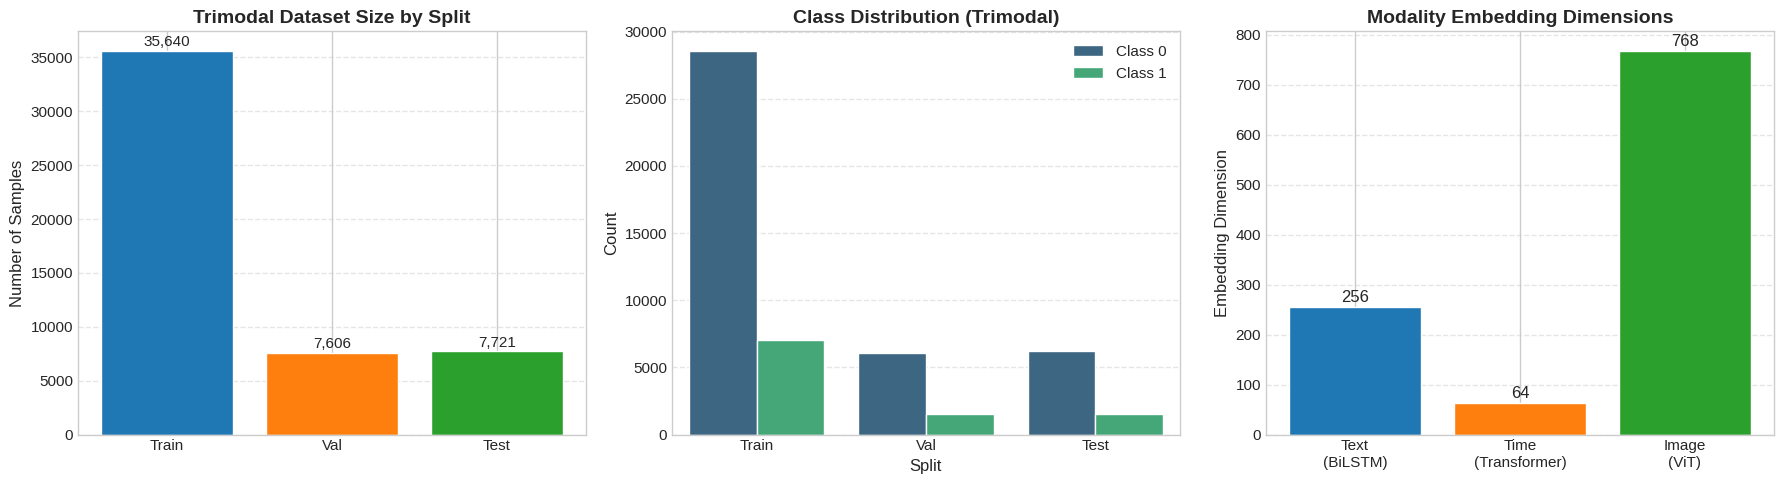

Saved: /content/trimodal_fusion/fusion_outputs/plots/01_trimodal_data_overview.png


In [14]:
# 3.1 Alignment Visualization
print("\n" + "="*60)
print("STEP 3: DATA VISUALIZATION")
print("="*60)

# Recreate output directories
PLOTS_DIR = Path(WORK_DIR) / "fusion_outputs" / "plots"
CALIB_DIR = Path(WORK_DIR) / "fusion_outputs" / "calibration"
MODEL_DIR = Path(WORK_DIR) / "fusion_outputs" / "models"
BASE_OUT_DIR = Path(WORK_DIR) / "fusion_outputs"

for d in [PLOTS_DIR, CALIB_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sample counts per split
ax1 = axes[0]
splits = ['Train', 'Val', 'Test']
counts = [len(ytr), len(yv), len(ys)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax1.bar(splits, counts, color=colors)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Trimodal Dataset Size by Split', fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
for bar, count in zip(bars, counts):
    ax1.annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=11)

# Plot 2: Class distribution
ax2 = axes[1]
class_data = []
for split, y_data in [('Train', ytr), ('Val', yv), ('Test', ys)]:
    unique, cnts = np.unique(y_data, return_counts=True)
    for label, cnt in zip(unique, cnts):
        class_data.append({'Split': split, 'Label': f'Class {int(label)}', 'Count': cnt})

class_df = pd.DataFrame(class_data)
sns.barplot(data=class_df, x='Split', y='Count', hue='Label', palette='viridis', ax=ax2)
ax2.set_title('Class Distribution (Trimodal)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Embedding dimension comparison
ax3 = axes[2]
modalities = ['Text\n(BiLSTM)', 'Time\n(Transformer)', 'Image\n(ViT)']
dims = [text_dim, time_dim, image_dim]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax3.bar(modalities, dims, color=colors)
ax3.set_ylabel('Embedding Dimension', fontsize=12)
ax3.set_title('Modality Embedding Dimensions', fontsize=14, fontweight='bold')
ax3.grid(axis='y', linestyle='--', alpha=0.5)
for bar, dim in zip(bars, dims):
    ax3.annotate(f'{dim}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "01_trimodal_data_overview.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / '01_trimodal_data_overview.png'}")

-  12. PyTorch Dataset and DataLoaders

In [15]:
# 4.1 PyTorch Dataset Class
print("\n" + "="*60)
print("STEP 4: CREATING PYTORCH DATASETS")
print("="*60)

class TrimodalDataset(Dataset):
    def __init__(self, text_emb, time_feat, image_emb, labels):
        assert len(text_emb) == len(time_feat) == len(image_emb) == len(labels)

        self.text_emb = torch.tensor(text_emb, dtype=torch.float32)
        self.time_feat = torch.tensor(time_feat, dtype=torch.float32)
        self.image_emb = torch.tensor(image_emb, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "text": self.text_emb[idx],
            "time": self.time_feat[idx],
            "image": self.image_emb[idx],
            "label": self.labels[idx],
        }

# 4.2 Create Datasets and DataLoaders
train_ds = TrimodalDataset(Xtr_text, Xtr_time, Xtr_image, ytr)
val_ds = TrimodalDataset(Xv_text, Xv_time, Xv_image, yv)
test_ds = TrimodalDataset(Xs_text, Xs_time, Xs_image, ys)

print(f"\nTrain dataset: {len(train_ds):,} samples")
print(f"Val dataset:   {len(val_ds):,} samples")
print(f"Test dataset:  {len(test_ds):,} samples")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Val loader:   {len(val_loader)} batches")
print(f"Test loader:  {len(test_loader)} batches")


STEP 4: CREATING PYTORCH DATASETS

Train dataset: 35,640 samples
Val dataset:   7,606 samples
Test dataset:  7,721 samples

Train loader: 279 batches
Val loader:   60 batches
Test loader:  61 batches


- 13: DataLoader Sanity Check

In [16]:
# 4.3 Sanity Check DataLoaders
def inspect_loader(loader, name, n_batches=3):
    print(f"\n--- {name} DataLoader Inspection ---")
    ys = []
    for i, batch in enumerate(loader):
        ys.append(batch["label"].detach().cpu())
        if i >= n_batches - 1:
            break
    ys = torch.cat(ys)
    counts = Counter(ys.tolist())
    total = sum(counts.values())
    print(f"  Class 0: {counts[0.0]:,} ({100*counts[0.0]/total:.1f}%)")
    print(f"  Class 1: {counts[1.0]:,} ({100*counts[1.0]/total:.1f}%)")

inspect_loader(train_loader, "TRAIN")
inspect_loader(val_loader, "VAL")
inspect_loader(test_loader, "TEST")

print("\nDataLoader verification complete")


--- TRAIN DataLoader Inspection ---
  Class 0: 309 (80.5%)
  Class 1: 75 (19.5%)

--- VAL DataLoader Inspection ---
  Class 0: 310 (80.7%)
  Class 1: 74 (19.3%)

--- TEST DataLoader Inspection ---
  Class 0: 306 (79.7%)
  Class 1: 78 (20.3%)

DataLoader verification complete


- 14: Model Architecture

In [17]:
# 5.1 Model Components
print("\n" + "="*60)
print("STEP 5: DEFINING MODEL ARCHITECTURES")
print("="*60)

class ModalityHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.net(x)
        return self.out(h).squeeze(-1), h

print("ModalityHead defined")


STEP 5: DEFINING MODEL ARCHITECTURES
ModalityHead defined


- 15. Trimodal Fusion Model

In [18]:
# 5.2 Trimodal Fusion Model
class TrimodalFusionModel(nn.Module):
    def __init__(self, text_dim, time_dim, image_dim, hidden_dim=256, dropout=0.3):
        super().__init__()

        self.text_head = ModalityHead(text_dim, hidden_dim, dropout)
        self.time_head = ModalityHead(time_dim, hidden_dim, dropout)
        self.image_head = ModalityHead(image_dim, hidden_dim, dropout)

        self.fusion_weights = nn.Parameter(torch.zeros(3))
        self.temperature = nn.Parameter(torch.ones(1))

    def get_fusion_weights(self):
        return F.softmax(self.fusion_weights / self.temperature, dim=0)

    def forward(self, text_x, time_x, image_x, mode="fusion", modality_dropout=0.0):
        logit_text, _ = self.text_head(text_x)
        logit_time, _ = self.time_head(time_x)
        logit_image, _ = self.image_head(image_x)

        if mode == "text":
            return logit_text
        elif mode == "time":
            return logit_time
        elif mode == "image":
            return logit_image
        elif mode == "text_time":
            w = F.softmax(self.fusion_weights[:2] / self.temperature, dim=0)
            return w[0] * logit_text + w[1] * logit_time
        elif mode == "text_image":
            w = F.softmax(self.fusion_weights[::2] / self.temperature, dim=0)
            return w[0] * logit_text + w[1] * logit_image
        elif mode == "time_image":
            w = F.softmax(self.fusion_weights[1:] / self.temperature, dim=0)
            return w[0] * logit_time + w[1] * logit_image
        else:  # "fusion"
            weights = self.get_fusion_weights()

            if self.training and modality_dropout > 0:
                mask = torch.ones(3, device=weights.device)
                for i in range(3):
                    if random.random() < modality_dropout:
                        mask[i] = 0
                if mask.sum() == 0:
                    mask[random.randint(0, 2)] = 1
                weights = weights * mask
                weights = weights / weights.sum()

            return weights[0] * logit_text + weights[1] * logit_time + weights[2] * logit_image

print("TrimodalFusionModel defined")

TrimodalFusionModel defined


-  16. Class Weights and Metrics

In [19]:
# 6.1 Compute Class Weights
print("\n" + "="*60)
print("STEP 6: COMPUTING CLASS WEIGHTS")
print("="*60)

all_train_labels = []
for batch in train_loader:
    all_train_labels.append(batch["label"].numpy())
all_train_labels = np.concatenate(all_train_labels)

neg = (all_train_labels == 0).sum()
pos = (all_train_labels == 1).sum()
pos_weight_value = neg / (pos + 1e-8)

print(f"\nClass distribution in training set:")
print(f"  Negative (y=0): {neg:,} ({100*neg/(neg+pos):.1f}%)")
print(f"  Positive (y=1): {pos:,} ({100*pos/(neg+pos):.1f}%)")
print(f"  Imbalance ratio: {neg/pos:.2f}:1")
print(f"\nComputed pos_weight: {pos_weight_value:.2f}")


# 6.2 Metrics Functions
def compute_ece(y_true, y_prob, n_bins=15):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(accuracy_in_bin - avg_confidence_in_bin) * prop_in_bin

    return ece


def binary_metrics(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)
    y_pred = (y_prob >= threshold).astype(int)

    auc_score = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp + 1e-8)

    ece = compute_ece(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)

    return {
        "auc": auc_score,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "accuracy": acc,
        "specificity": spec,
        "ece": ece,
        "brier": brier,
        "confusion": (tn, fp, fn, tp),
    }

print("Metrics functions defined (including ECE and Brier Score)")


STEP 6: COMPUTING CLASS WEIGHTS

Class distribution in training set:
  Negative (y=0): 28,590 (80.2%)
  Positive (y=1): 7,050 (19.8%)
  Imbalance ratio: 4.06:1

Computed pos_weight: 4.06
Metrics functions defined (including ECE and Brier Score)


- 17. Plotting Functions

In [20]:
# 6.3 Plotting Functions
def plot_training_curves(history, model_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax1 = axes[0]
    ax1.plot(epochs, history["train_loss"], label="Train Loss", marker='o', linewidth=2)
    ax1.plot(epochs, history["val_loss"], label="Val Loss", marker='s', linewidth=2)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Binary Cross-Entropy Loss", fontsize=12)
    ax1.set_title(f"{model_name} - Training Curves", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    ax2.plot(epochs, history["val_auc"], marker="o", linewidth=2, color='green')
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Validation AUC", fontsize=12)
    ax2.set_title(f"{model_name} - Validation Performance", fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0.45, 1.0])

    plt.tight_layout()
    path = PLOTS_DIR / f"{model_name}_training.png"
    plt.savefig(path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved training curves: {path}")


def plot_confusion_matrix(cm, model_name):
    tn, fp, fn, tp = cm
    mat = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["True 0", "True 1"],
                cbar_kws={'label': 'Count'})
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel("True Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.tight_layout()

    path = PLOTS_DIR / f"{model_name}_confusion.png"
    plt.savefig(path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved confusion matrix: {path}")

print("Plotting functions defined")

Plotting functions defined


- 18. Training Function

In [21]:
# 7.1 Training Function
print("\n" + "="*60)
print("STEP 7: TRAINING INFRASTRUCTURE")
print("="*60)

def train_model(model, train_loader, val_loader, mode="fusion",
                n_epochs=20, lr=1e-3, weight_decay=1e-4,
                patience=5, model_name="Fusion", use_modality_dropout=False):

    model = model.to(device)

    pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "val_auc": []}
    best_state = None
    best_auc = 0.0
    no_improve = 0

    print(f"\n{'='*60}")
    print(f"Training {model_name} ({mode} mode)")
    print(f"{'='*60}")

    mod_dropout = MODALITY_DROPOUT if (use_modality_dropout and mode == "fusion") else 0.0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            text_x = batch["text"].to(device)
            time_x = batch["time"].to(device)
            image_x = batch["image"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(text_x, time_x, image_x, mode=mode, modality_dropout=mod_dropout)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        all_probs, all_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                text_x = batch["text"].to(device)
                time_x = batch["time"].to(device)
                image_x = batch["image"].to(device)
                labels = batch["label"].to(device)

                logits = model(text_x, time_x, image_x, mode=mode, modality_dropout=0.0)
                loss = criterion(logits, labels)
                val_loss += loss.item() * labels.size(0)

                probs = torch.sigmoid(logits).cpu().numpy()
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        all_probs = np.concatenate(all_probs)
        all_labels = np.concatenate(all_labels)

        metrics = binary_metrics(all_labels, all_probs)
        val_auc = metrics["auc"]

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_auc"].append(val_auc)

        print(f"  Epoch {epoch:02d}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val AUC: {val_auc:.4f}")

        if val_auc > best_auc + 1e-4:
            best_auc = val_auc
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\n  Early stopping triggered (patience={patience})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nRestored best model (Val AUC: {best_auc:.4f})")

    plot_training_curves(history, model_name=f"{model_name}_{mode}")

    return model, history, best_auc

print("Training function defined")


STEP 7: TRAINING INFRASTRUCTURE
Training function defined


- 19. Evaluation Function

In [22]:
# 7.2 Evaluation Function
def evaluate_model(model, loader, mode="fusion", model_name="Fusion"):
    model = model.to(device)
    model.eval()

    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            text_x = batch["text"].to(device)
            time_x = batch["time"].to(device)
            image_x = batch["image"].to(device)
            labels = batch["label"].cpu().numpy()

            logits = model(text_x, time_x, image_x, mode=mode, modality_dropout=0.0)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(labels)

    y_prob = np.concatenate(all_probs)
    y_true = np.concatenate(all_labels)

    metrics = binary_metrics(y_true, y_prob)

    print(f"\n{'='*60}")
    print(f"{model_name} ({mode}) - TEST SET RESULTS")
    print(f"{'='*60}")
    print(f"  AUC:         {metrics['auc']:.4f}")
    print(f"  F1-Score:    {metrics['f1']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")
    print(f"  Specificity: {metrics['specificity']:.4f}")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  ECE:         {metrics['ece']:.4f} ({metrics['ece']*100:.2f}%)")
    print(f"  Brier Score: {metrics['brier']:.4f}")

    tn, fp, fn, tp = metrics["confusion"]
    print(f"\n  Confusion Matrix:")
    print(f"    TN={tn:,}  FP={fp:,}")
    print(f"    FN={fn:,}  TP={tp:,}")

    plot_confusion_matrix(metrics["confusion"], model_name=f"{model_name}_{mode}")

    return y_true, y_prob, metrics

print("Evaluation function defined")

Evaluation function defined


- 20. Experiment 1 - Text-Only


EXPERIMENT 1: TEXT-ONLY MODEL

Training Text_Only (text mode)
  Epoch 01/20 | Train Loss: 0.7058 | Val Loss: 0.8873 | Val AUC: 0.8101
  Epoch 02/20 | Train Loss: 0.6960 | Val Loss: 0.8881 | Val AUC: 0.8116
  Epoch 03/20 | Train Loss: 0.6921 | Val Loss: 0.9281 | Val AUC: 0.8112
  Epoch 04/20 | Train Loss: 0.6932 | Val Loss: 0.8770 | Val AUC: 0.8096
  Epoch 05/20 | Train Loss: 0.6885 | Val Loss: 0.8894 | Val AUC: 0.8072
  Epoch 06/20 | Train Loss: 0.6890 | Val Loss: 0.9138 | Val AUC: 0.8107
  Epoch 07/20 | Train Loss: 0.6875 | Val Loss: 0.9070 | Val AUC: 0.8111

  Early stopping triggered (patience=5)

Restored best model (Val AUC: 0.8116)


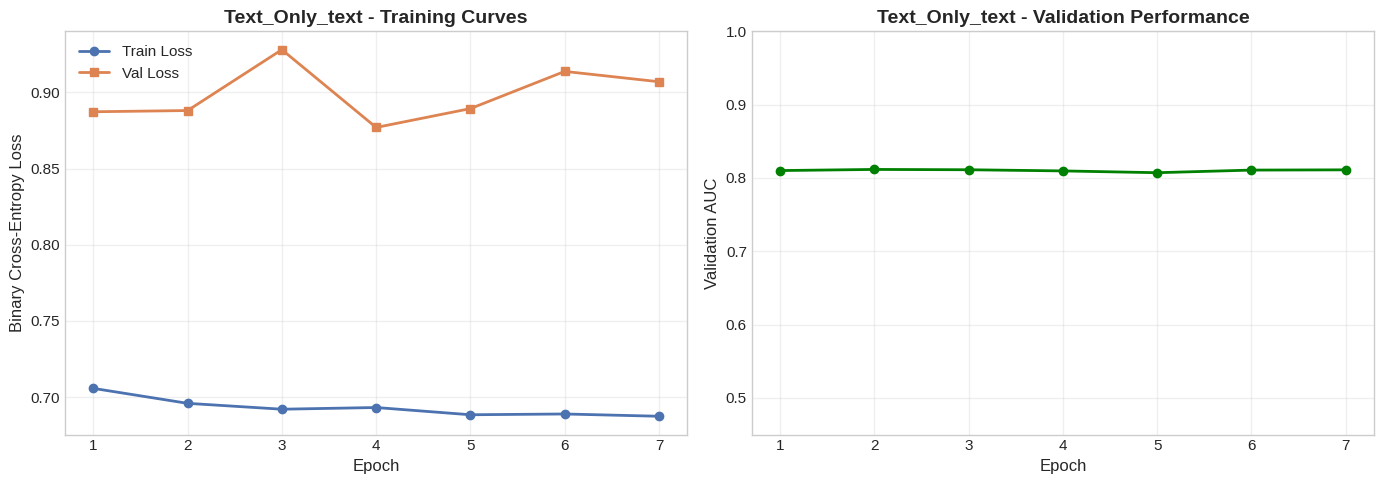

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Text_Only_text_training.png

Text_Only (text) - TEST SET RESULTS
  AUC:         0.7983
  F1-Score:    0.5219
  Precision:   0.4370
  Recall:      0.6477
  Specificity: 0.7943
  Accuracy:    0.7653
  ECE:         0.1582 (15.82%)
  Brier Score: 0.1689

  Confusion Matrix:
    TN=4,920  FP=1,274
    FN=538  TP=989


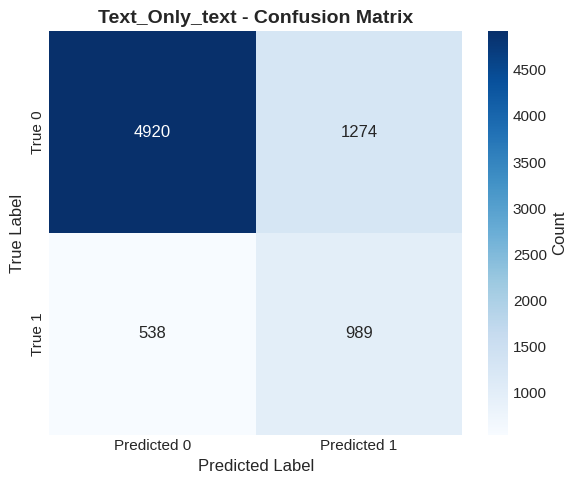

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Text_Only_text_confusion.png


In [23]:
# 8.1 Text-Only Model
print("\n" + "="*60)
print("EXPERIMENT 1: TEXT-ONLY MODEL")
print("="*60)

clear_gpu()
text_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                  hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

text_model, hist_text, val_auc_text = train_model(
    text_model, train_loader, val_loader,
    mode="text", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Text_Only"
)

y_text_test, p_text_test, metrics_text = evaluate_model(
    text_model, test_loader, mode="text", model_name="Text_Only"
)

- 21. Experiment 2 - Time-Only


EXPERIMENT 2: TIME-ONLY MODEL

Training Time_Only (time mode)
  Epoch 01/20 | Train Loss: 1.0345 | Val Loss: 1.0709 | Val AUC: 0.6675
  Epoch 02/20 | Train Loss: 1.0225 | Val Loss: 1.0700 | Val AUC: 0.6763
  Epoch 03/20 | Train Loss: 1.0190 | Val Loss: 1.0630 | Val AUC: 0.6794
  Epoch 04/20 | Train Loss: 1.0186 | Val Loss: 1.0758 | Val AUC: 0.6701
  Epoch 05/20 | Train Loss: 1.0181 | Val Loss: 1.0883 | Val AUC: 0.6734
  Epoch 06/20 | Train Loss: 1.0154 | Val Loss: 1.0480 | Val AUC: 0.6775
  Epoch 07/20 | Train Loss: 1.0178 | Val Loss: 1.0600 | Val AUC: 0.6785
  Epoch 08/20 | Train Loss: 1.0156 | Val Loss: 1.0786 | Val AUC: 0.6668

  Early stopping triggered (patience=5)

Restored best model (Val AUC: 0.6794)


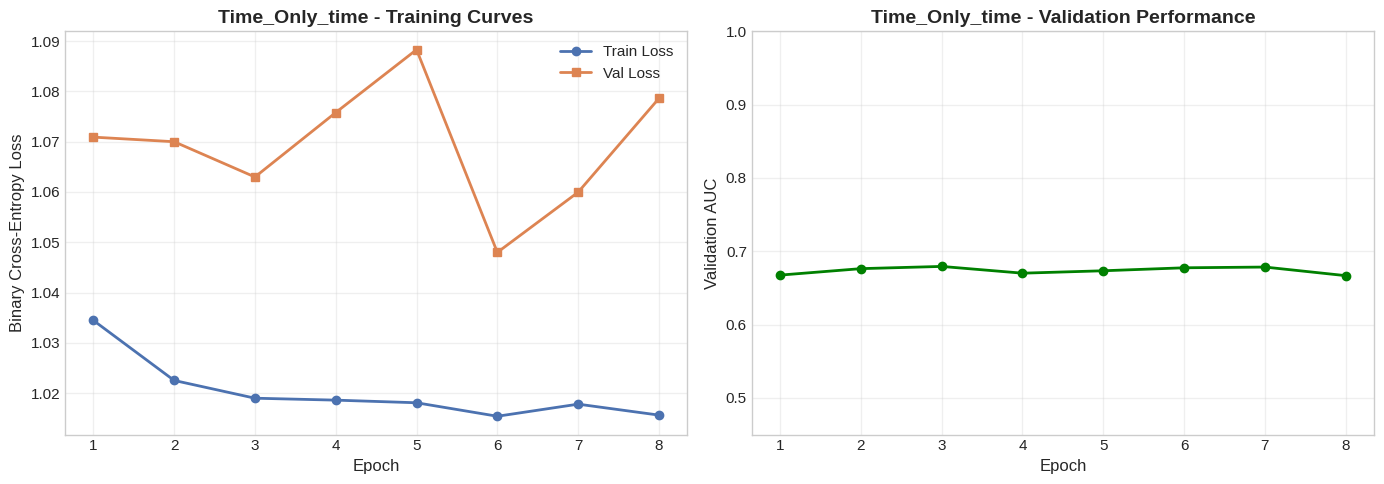

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Time_Only_time_training.png

Time_Only (time) - TEST SET RESULTS
  AUC:         0.6698
  F1-Score:    0.3949
  Precision:   0.2650
  Recall:      0.7747
  Specificity: 0.4703
  Accuracy:    0.5305
  ECE:         0.3085 (30.85%)
  Brier Score: 0.2559

  Confusion Matrix:
    TN=2,913  FP=3,281
    FN=344  TP=1,183


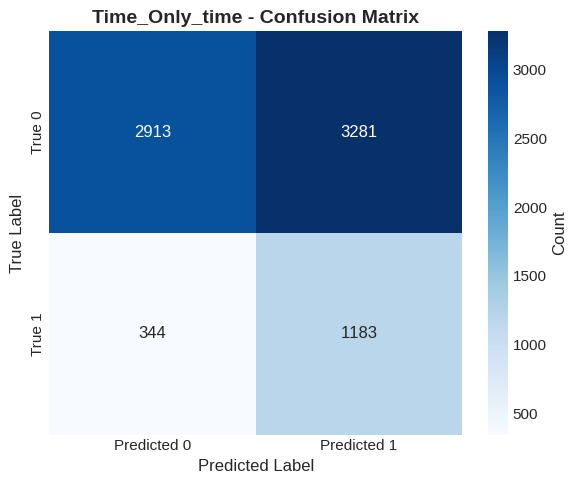

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Time_Only_time_confusion.png


In [24]:
# 8.2 Time-Only Model
print("\n" + "="*60)
print("EXPERIMENT 2: TIME-ONLY MODEL")
print("="*60)

clear_gpu()
time_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                  hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

time_model, hist_time, val_auc_time = train_model(
    time_model, train_loader, val_loader,
    mode="time", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Time_Only"
)

y_time_test, p_time_test, metrics_time = evaluate_model(
    time_model, test_loader, mode="time", model_name="Time_Only"
)

- 22. Experiment 3 - Image-Only


EXPERIMENT 3: IMAGE-ONLY MODEL

Training Image_Only (image mode)
  Epoch 01/20 | Train Loss: 1.0688 | Val Loss: 1.0510 | Val AUC: 0.6598
  Epoch 02/20 | Train Loss: 1.0538 | Val Loss: 1.0630 | Val AUC: 0.6569
  Epoch 03/20 | Train Loss: 1.0474 | Val Loss: 1.0467 | Val AUC: 0.6657
  Epoch 04/20 | Train Loss: 1.0431 | Val Loss: 1.0468 | Val AUC: 0.6671
  Epoch 05/20 | Train Loss: 1.0447 | Val Loss: 1.0462 | Val AUC: 0.6676
  Epoch 06/20 | Train Loss: 1.0438 | Val Loss: 1.0440 | Val AUC: 0.6670
  Epoch 07/20 | Train Loss: 1.0440 | Val Loss: 1.0512 | Val AUC: 0.6626
  Epoch 08/20 | Train Loss: 1.0405 | Val Loss: 1.0539 | Val AUC: 0.6623
  Epoch 09/20 | Train Loss: 1.0428 | Val Loss: 1.0439 | Val AUC: 0.6673
  Epoch 10/20 | Train Loss: 1.0408 | Val Loss: 1.0428 | Val AUC: 0.6678
  Epoch 11/20 | Train Loss: 1.0412 | Val Loss: 1.0442 | Val AUC: 0.6663
  Epoch 12/20 | Train Loss: 1.0402 | Val Loss: 1.0454 | Val AUC: 0.6680
  Epoch 13/20 | Train Loss: 1.0409 | Val Loss: 1.0486 | Val AUC: 0.664

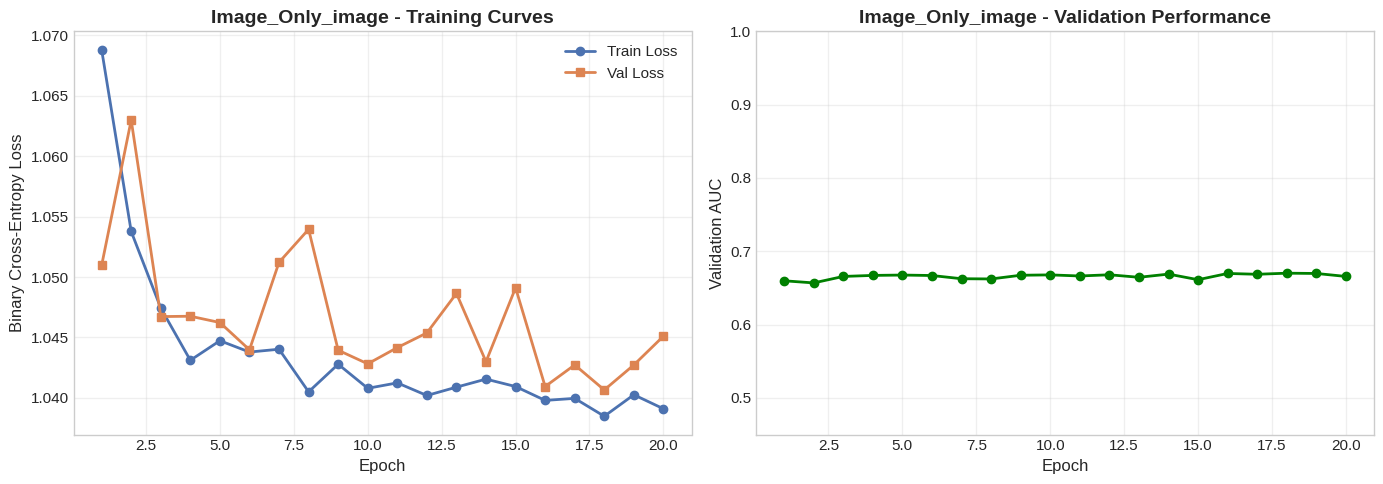

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Image_Only_image_training.png

Image_Only (image) - TEST SET RESULTS
  AUC:         0.6350
  F1-Score:    0.3747
  Precision:   0.2570
  Recall:      0.6916
  Specificity: 0.5071
  Accuracy:    0.5436
  ECE:         0.2826 (28.26%)
  Brier Score: 0.2418

  Confusion Matrix:
    TN=3,141  FP=3,053
    FN=471  TP=1,056


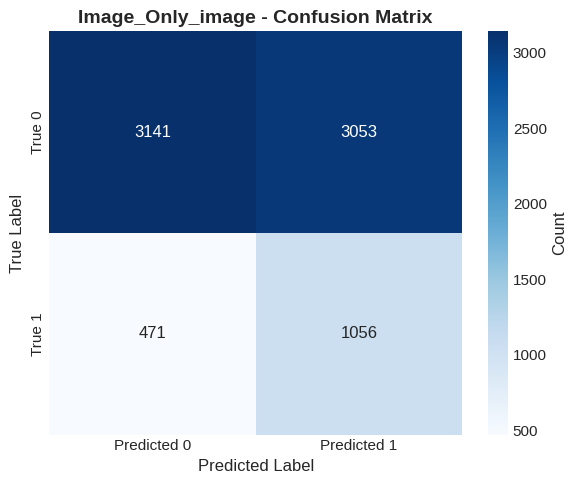

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Image_Only_image_confusion.png


In [25]:
# 8.3 Image-Only Model
print("\n" + "="*60)
print("EXPERIMENT 3: IMAGE-ONLY MODEL")
print("="*60)

clear_gpu()
image_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                   hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

image_model, hist_image, val_auc_image = train_model(
    image_model, train_loader, val_loader,
    mode="image", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Image_Only"
)

y_image_test, p_image_test, metrics_image = evaluate_model(
    image_model, test_loader, mode="image", model_name="Image_Only"
)

- 23. Experiment 4 - Text+Time Fusion


EXPERIMENT 4: TEXT + TIME FUSION

Training Text_Time (text_time mode)
  Epoch 01/20 | Train Loss: 0.6905 | Val Loss: 0.8796 | Val AUC: 0.8191
  Epoch 02/20 | Train Loss: 0.6753 | Val Loss: 0.8583 | Val AUC: 0.8185
  Epoch 03/20 | Train Loss: 0.6715 | Val Loss: 0.8775 | Val AUC: 0.8197
  Epoch 04/20 | Train Loss: 0.6716 | Val Loss: 0.8667 | Val AUC: 0.8168
  Epoch 05/20 | Train Loss: 0.6703 | Val Loss: 0.8755 | Val AUC: 0.8175
  Epoch 06/20 | Train Loss: 0.6702 | Val Loss: 0.8747 | Val AUC: 0.8145
  Epoch 07/20 | Train Loss: 0.6678 | Val Loss: 0.8869 | Val AUC: 0.8160
  Epoch 08/20 | Train Loss: 0.6643 | Val Loss: 0.8797 | Val AUC: 0.8154

  Early stopping triggered (patience=5)

Restored best model (Val AUC: 0.8197)


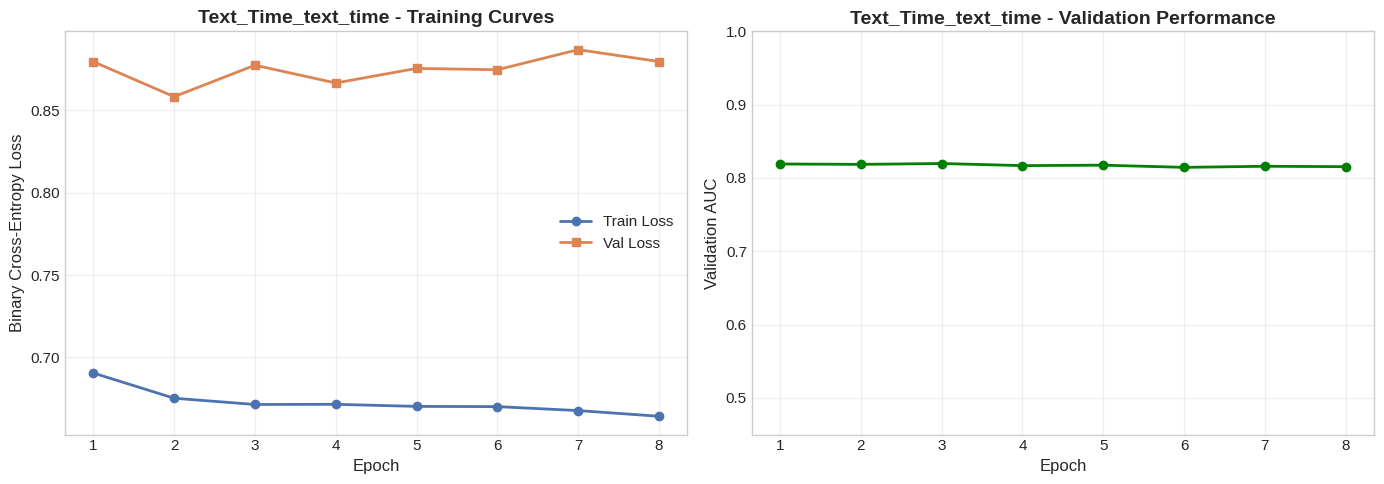

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Text_Time_text_time_training.png

Text_Time (text_time) - TEST SET RESULTS
  AUC:         0.8071
  F1-Score:    0.5224
  Precision:   0.4306
  Recall:      0.6640
  Specificity: 0.7835
  Accuracy:    0.7599
  ECE:         0.1597 (15.97%)
  Brier Score: 0.1647

  Confusion Matrix:
    TN=4,853  FP=1,341
    FN=513  TP=1,014


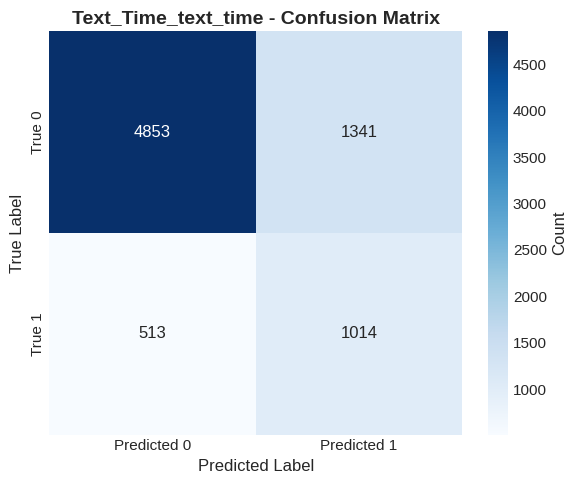

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Text_Time_text_time_confusion.png


In [26]:
# 8.4 Text+Time Fusion
print("\n" + "="*60)
print("EXPERIMENT 4: TEXT + TIME FUSION")
print("="*60)

clear_gpu()
text_time_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                       hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

text_time_model, hist_text_time, val_auc_text_time = train_model(
    text_time_model, train_loader, val_loader,
    mode="text_time", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Text_Time"
)

y_text_time_test, p_text_time_test, metrics_text_time = evaluate_model(
    text_time_model, test_loader, mode="text_time", model_name="Text_Time"
)

- 24. Experiment 5 - Text+Image Fusion


EXPERIMENT 5: TEXT + IMAGE FUSION

Training Text_Image (text_image mode)
  Epoch 01/20 | Train Loss: 0.7008 | Val Loss: 0.8910 | Val AUC: 0.8149
  Epoch 02/20 | Train Loss: 0.6921 | Val Loss: 0.8811 | Val AUC: 0.8132
  Epoch 03/20 | Train Loss: 0.6908 | Val Loss: 0.8942 | Val AUC: 0.8143
  Epoch 04/20 | Train Loss: 0.6876 | Val Loss: 0.8683 | Val AUC: 0.8151
  Epoch 05/20 | Train Loss: 0.6859 | Val Loss: 0.8878 | Val AUC: 0.8130
  Epoch 06/20 | Train Loss: 0.6856 | Val Loss: 0.8792 | Val AUC: 0.8155
  Epoch 07/20 | Train Loss: 0.6816 | Val Loss: 0.8813 | Val AUC: 0.8127
  Epoch 08/20 | Train Loss: 0.6842 | Val Loss: 0.8871 | Val AUC: 0.8146
  Epoch 09/20 | Train Loss: 0.6805 | Val Loss: 0.8825 | Val AUC: 0.8103
  Epoch 10/20 | Train Loss: 0.6815 | Val Loss: 0.8757 | Val AUC: 0.8159
  Epoch 11/20 | Train Loss: 0.6779 | Val Loss: 0.8865 | Val AUC: 0.8123
  Epoch 12/20 | Train Loss: 0.6803 | Val Loss: 0.8837 | Val AUC: 0.8158
  Epoch 13/20 | Train Loss: 0.6762 | Val Loss: 0.9067 | Val AU

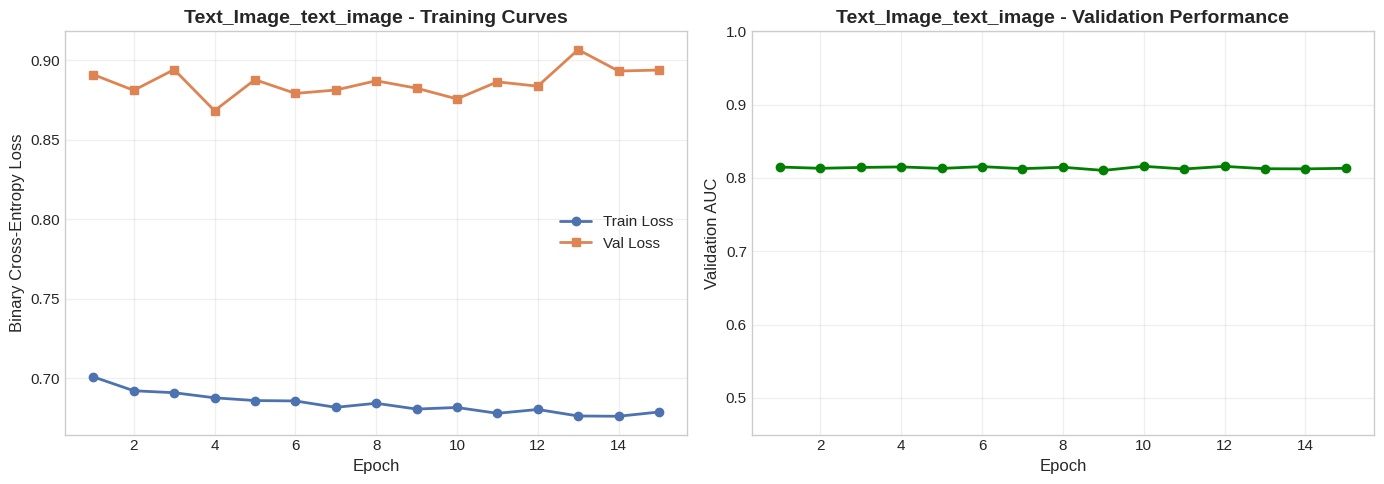

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Text_Image_text_image_training.png

Text_Image (text_image) - TEST SET RESULTS
  AUC:         0.7979
  F1-Score:    0.5245
  Precision:   0.4340
  Recall:      0.6627
  Specificity: 0.7869
  Accuracy:    0.7623
  ECE:         0.1566 (15.66%)
  Brier Score: 0.1683

  Confusion Matrix:
    TN=4,874  FP=1,320
    FN=515  TP=1,012


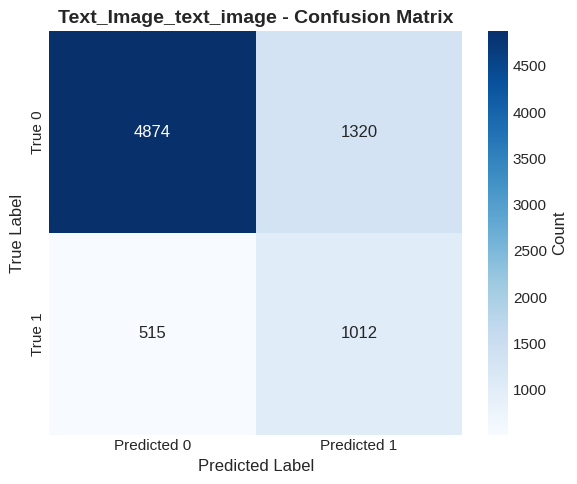

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Text_Image_text_image_confusion.png


In [27]:
# 8.5 Text+Image Fusion
print("\n" + "="*60)
print("EXPERIMENT 5: TEXT + IMAGE FUSION")
print("="*60)

clear_gpu()
text_image_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                        hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

text_image_model, hist_text_image, val_auc_text_image = train_model(
    text_image_model, train_loader, val_loader,
    mode="text_image", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Text_Image"
)

y_text_image_test, p_text_image_test, metrics_text_image = evaluate_model(
    text_image_model, test_loader, mode="text_image", model_name="Text_Image"
)

- 25. Experiment 6 - Time+Image Fusion


EXPERIMENT 6: TIME + IMAGE FUSION

Training Time_Image (time_image mode)
  Epoch 01/20 | Train Loss: 0.9953 | Val Loss: 1.0085 | Val AUC: 0.7193
  Epoch 02/20 | Train Loss: 0.9840 | Val Loss: 1.0040 | Val AUC: 0.7115
  Epoch 03/20 | Train Loss: 0.9773 | Val Loss: 1.0238 | Val AUC: 0.7062
  Epoch 04/20 | Train Loss: 0.9788 | Val Loss: 1.0112 | Val AUC: 0.7122
  Epoch 05/20 | Train Loss: 0.9752 | Val Loss: 1.0180 | Val AUC: 0.7096
  Epoch 06/20 | Train Loss: 0.9759 | Val Loss: 1.0198 | Val AUC: 0.7138

  Early stopping triggered (patience=5)

Restored best model (Val AUC: 0.7193)


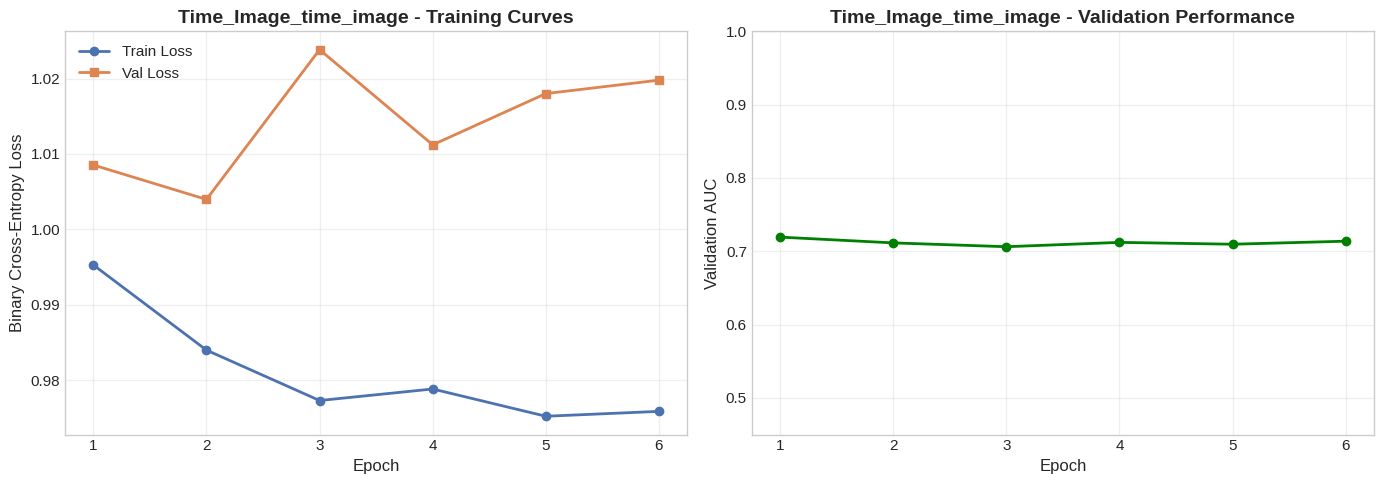

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Time_Image_time_image_training.png

Time_Image (time_image) - TEST SET RESULTS
  AUC:         0.6979
  F1-Score:    0.4159
  Precision:   0.2859
  Recall:      0.7623
  Specificity: 0.5307
  Accuracy:    0.5765
  ECE:         0.2880 (28.80%)
  Brier Score: 0.2408

  Confusion Matrix:
    TN=3,287  FP=2,907
    FN=363  TP=1,164


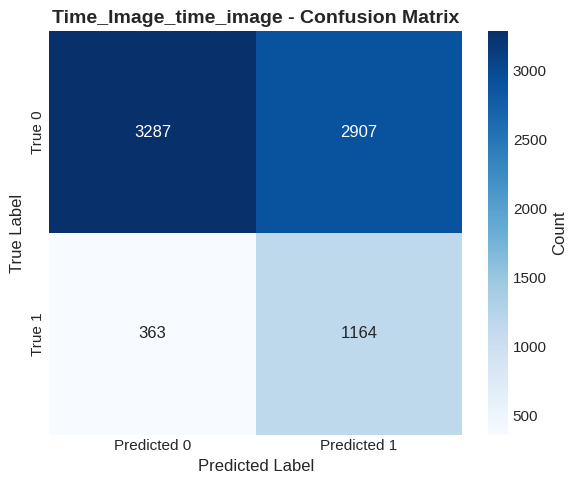

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Time_Image_time_image_confusion.png


In [28]:
# 8.6 Time+Image Fusion
print("\n" + "="*60)
print("EXPERIMENT 6: TIME + IMAGE FUSION")
print("="*60)

clear_gpu()
time_image_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                        hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

time_image_model, hist_time_image, val_auc_time_image = train_model(
    time_image_model, train_loader, val_loader,
    mode="time_image", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Time_Image"
)

y_time_image_test, p_time_image_test, metrics_time_image = evaluate_model(
    time_image_model, test_loader, mode="time_image", model_name="Time_Image"
)

- 26 Experiment 7 - Trimodal Fusion


EXPERIMENT 7: TRIMODAL FUSION (ALL THREE)

Training Trimodal_Fusion (fusion mode)
  Epoch 01/20 | Train Loss: 0.8241 | Val Loss: 0.8379 | Val AUC: 0.8250
  Epoch 02/20 | Train Loss: 0.7861 | Val Loss: 0.8518 | Val AUC: 0.8240
  Epoch 03/20 | Train Loss: 0.7732 | Val Loss: 0.8347 | Val AUC: 0.8246
  Epoch 04/20 | Train Loss: 0.7830 | Val Loss: 0.8430 | Val AUC: 0.8226
  Epoch 05/20 | Train Loss: 0.7720 | Val Loss: 0.8558 | Val AUC: 0.8201
  Epoch 06/20 | Train Loss: 0.7799 | Val Loss: 0.8558 | Val AUC: 0.8207

  Early stopping triggered (patience=5)

Restored best model (Val AUC: 0.8250)


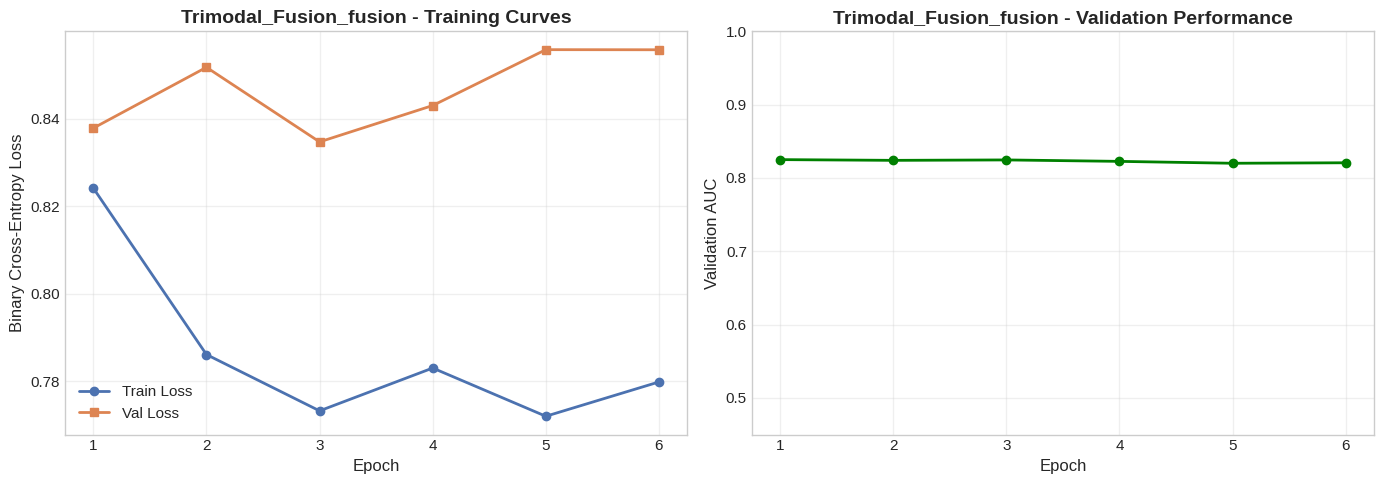

Saved training curves: /content/trimodal_fusion/fusion_outputs/plots/Trimodal_Fusion_fusion_training.png

Trimodal_Fusion (fusion) - TEST SET RESULTS
  AUC:         0.8068
  F1-Score:    0.5282
  Precision:   0.4237
  Recall:      0.7014
  Specificity: 0.7648
  Accuracy:    0.7522
  ECE:         0.1807 (18.07%)
  Brier Score: 0.1722

  Confusion Matrix:
    TN=4,737  FP=1,457
    FN=456  TP=1,071


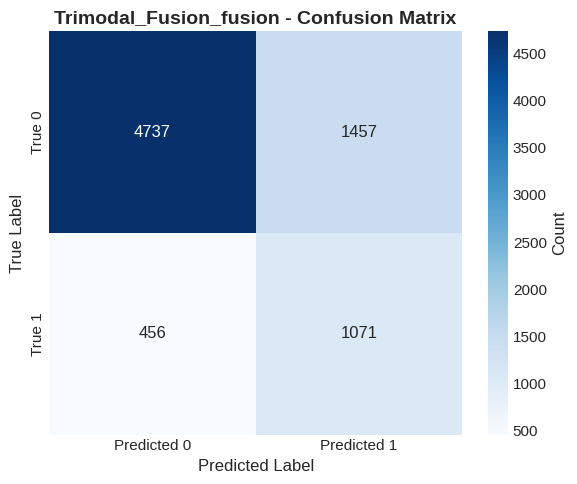

Saved confusion matrix: /content/trimodal_fusion/fusion_outputs/plots/Trimodal_Fusion_fusion_confusion.png

Learned fusion weights:
  Text:  0.614 (61.4%)
  Time:  0.215 (21.5%)
  Image: 0.171 (17.1%)


In [29]:
# 8.7 Trimodal Fusion
print("\n" + "="*60)
print("EXPERIMENT 7: TRIMODAL FUSION (ALL THREE)")
print("="*60)

clear_gpu()
trimodal_model = TrimodalFusionModel(text_dim, time_dim, image_dim,
                                      hidden_dim=HIDDEN_DIM, dropout=DROPOUT)

trimodal_model, hist_trimodal, val_auc_trimodal = train_model(
    trimodal_model, train_loader, val_loader,
    mode="fusion", n_epochs=N_EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, patience=PATIENCE,
    model_name="Trimodal_Fusion", use_modality_dropout=True
)

y_trimodal_test, p_trimodal_test, metrics_trimodal = evaluate_model(
    trimodal_model, test_loader, mode="fusion", model_name="Trimodal_Fusion"
)

# Inspect learned fusion weights
with torch.no_grad():
    weights = trimodal_model.get_fusion_weights().cpu().numpy()
print(f"\nLearned fusion weights:")
print(f"  Text:  {weights[0]:.3f} ({weights[0]*100:.1f}%)")
print(f"  Time:  {weights[1]:.3f} ({weights[1]*100:.1f}%)")
print(f"  Image: {weights[2]:.3f} ({weights[2]*100:.1f}%)")

- 27. Performance Summary

In [30]:
# 9.1 Performance Summary Table
print("\n" + "="*60)
print("SUMMARY: MODEL COMPARISON")
print("="*60)

summary_data = {
    'Model': ['Text-Only', 'Time-Only', 'Image-Only',
              'Text+Time', 'Text+Image', 'Time+Image', 'Trimodal'],
    'Val AUC': [val_auc_text, val_auc_time, val_auc_image,
                val_auc_text_time, val_auc_text_image, val_auc_time_image, val_auc_trimodal],
    'Test AUC': [metrics_text['auc'], metrics_time['auc'], metrics_image['auc'],
                 metrics_text_time['auc'], metrics_text_image['auc'],
                 metrics_time_image['auc'], metrics_trimodal['auc']],
    'F1': [metrics_text['f1'], metrics_time['f1'], metrics_image['f1'],
           metrics_text_time['f1'], metrics_text_image['f1'],
           metrics_time_image['f1'], metrics_trimodal['f1']],
    'ECE': [metrics_text['ece'], metrics_time['ece'], metrics_image['ece'],
            metrics_text_time['ece'], metrics_text_image['ece'],
            metrics_time_image['ece'], metrics_trimodal['ece']],
    'Brier': [metrics_text['brier'], metrics_time['brier'], metrics_image['brier'],
              metrics_text_time['brier'], metrics_text_image['brier'],
              metrics_time_image['brier'], metrics_trimodal['brier']],
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

best_idx = summary_df['Test AUC'].idxmax()
best_model_name = summary_df.loc[best_idx, 'Model']
best_auc = summary_df.loc[best_idx, 'Test AUC']
print(f"\nBEST MODEL: {best_model_name} (Test AUC = {best_auc:.4f})")


SUMMARY: MODEL COMPARISON

     Model  Val AUC  Test AUC       F1      ECE    Brier
 Text-Only 0.811634  0.798336 0.521900 0.158161 0.168862
 Time-Only 0.679356  0.669812 0.394926 0.308472 0.255860
Image-Only 0.670134  0.634974 0.374734 0.282648 0.241788
 Text+Time 0.819729  0.807138 0.522411 0.159721 0.164714
Text+Image 0.815899  0.797871 0.524488 0.156613 0.168301
Time+Image 0.719328  0.697885 0.415863 0.288010 0.240832
  Trimodal 0.825031  0.806831 0.528237 0.180669 0.172161

BEST MODEL: Text+Time (Test AUC = 0.8071)


-  28. ROC Curve Comparison

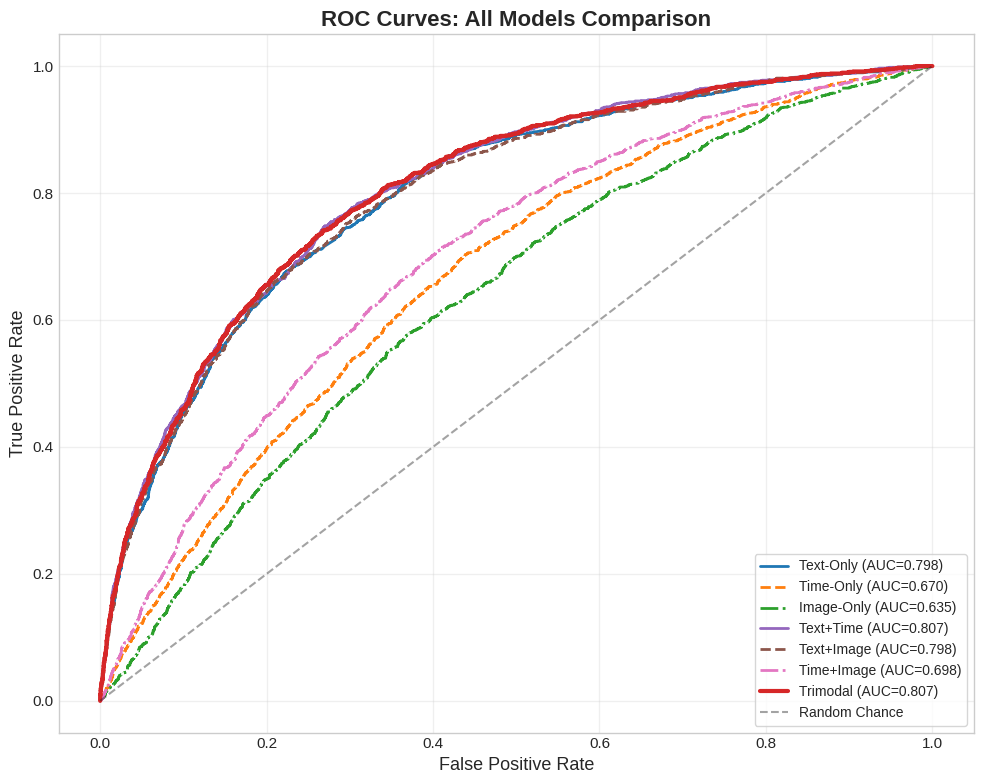

Saved ROC comparison: /content/trimodal_fusion/fusion_outputs/plots/02_roc_comparison_all.png


In [31]:
# 9.2 ROC Curve Comparison
fig, ax = plt.subplots(figsize=(10, 8))

roc_data = [
    (y_text_test, p_text_test, 'Text-Only', '#1f77b4', '-'),
    (y_time_test, p_time_test, 'Time-Only', '#ff7f0e', '--'),
    (y_image_test, p_image_test, 'Image-Only', '#2ca02c', '-.'),
    (y_text_time_test, p_text_time_test, 'Text+Time', '#9467bd', '-'),
    (y_text_image_test, p_text_image_test, 'Text+Image', '#8c564b', '--'),
    (y_time_image_test, p_time_image_test, 'Time+Image', '#e377c2', '-.'),
    (y_trimodal_test, p_trimodal_test, 'Trimodal', '#d62728', '-'),
]

for y_true, y_prob, name, color, style in roc_data:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)
    lw = 3 if name == 'Trimodal' else 2
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.3f})',
            color=color, linestyle=style, linewidth=lw)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Random Chance')
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves: All Models Comparison', fontsize=16, fontweight='bold')
ax.legend(loc="lower right", fontsize=10, frameon=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "02_roc_comparison_all.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved ROC comparison: {PLOTS_DIR / '02_roc_comparison_all.png'}")

- 30. Temperature Scaling

In [32]:
# 10.1 Temperature Scaling
print("\n" + "="*60)
print("STEP 10: PROBABILITY CALIBRATION")
print("="*60)

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_T = nn.Parameter(torch.zeros(1))

    def forward(self, logits):
        T = torch.exp(self.log_T)
        return logits / T

def fit_temperature(model, val_loader, mode="fusion"):
    model.eval()
    logits_list, labels_list = [], []

    print("Collecting validation logits...")
    with torch.no_grad():
        for batch in val_loader:
            text_x = batch["text"].to(device)
            time_x = batch["time"].to(device)
            image_x = batch["image"].to(device)
            labels = batch["label"].float().to(device)

            logits = model(text_x, time_x, image_x, mode=mode, modality_dropout=0.0)
            if logits.ndim > 1:
                logits = logits.squeeze(-1)

            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    scaler = TemperatureScaler().to(device)
    optimizer = torch.optim.LBFGS([scaler.log_T], lr=0.01, max_iter=50)
    criterion = nn.BCEWithLogitsLoss()

    def _closure():
        optimizer.zero_grad()
        scaled_logits = scaler(logits)
        loss = criterion(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(_closure)

    T = torch.exp(scaler.log_T).item()
    print(f"Optimal temperature: T = {T:.3f}")

    return scaler

clear_gpu()
temp_scaler = fit_temperature(trimodal_model, val_loader, mode="fusion")


STEP 10: PROBABILITY CALIBRATION
Optimal temperature: T = 1.088


- 31. Apply Calibration and Compare

In [33]:
# 10.2 Apply Calibration to Test Set
print("\nApplying calibration to test set...")

trimodal_model.eval()
logits_uncal, logits_cal, labels_test = [], [], []

with torch.no_grad():
    for batch in test_loader:
        text_x = batch["text"].to(device)
        time_x = batch["time"].to(device)
        image_x = batch["image"].to(device)
        labels = batch["label"].cpu().numpy()

        logits = trimodal_model(text_x, time_x, image_x, mode="fusion", modality_dropout=0.0)
        if logits.ndim > 1:
            logits = logits.squeeze(-1)

        logits_uncal.append(logits.cpu().numpy())
        logits_cal.append(temp_scaler(logits).cpu().numpy())
        labels_test.append(labels)

logits_uncal = np.concatenate(logits_uncal)
logits_cal = np.concatenate(logits_cal)
labels_test = np.concatenate(labels_test)

probs_uncal = 1 / (1 + np.exp(-logits_uncal))
probs_cal = 1 / (1 + np.exp(-logits_cal))

metrics_uncal = binary_metrics(labels_test, probs_uncal)
metrics_cal = binary_metrics(labels_test, probs_cal)

print(f"\n{'='*60}")
print("CALIBRATION COMPARISON (Test Set)")
print(f"{'='*60}")
print(f"                  Uncalibrated    Calibrated")
print(f"  AUC:            {metrics_uncal['auc']:.4f}          {metrics_cal['auc']:.4f}")
print(f"  F1-Score:       {metrics_uncal['f1']:.4f}          {metrics_cal['f1']:.4f}")
print(f"  ECE:            {metrics_uncal['ece']*100:.2f}%          {metrics_cal['ece']*100:.2f}%")
print(f"  Brier Score:    {metrics_uncal['brier']:.4f}          {metrics_cal['brier']:.4f}")


Applying calibration to test set...

CALIBRATION COMPARISON (Test Set)
                  Uncalibrated    Calibrated
  AUC:            0.8068          0.8068
  F1-Score:       0.5282          0.5282
  ECE:            18.07%          18.57%
  Brier Score:    0.1722          0.1715


 - Alternative calibration: Isotonic Regression

In [39]:
# Alternative calibration: Isotonic Regression
from sklearn.isotonic import IsotonicRegression

print("="*60)
print("ISOTONIC REGRESSION CALIBRATION")
print("="*60)

# Get validation set predictions for fitting
trimodal_model.eval()
val_logits, val_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        text_x = batch["text"].to(device)
        time_x = batch["time"].to(device)
        image_x = batch["image"].to(device)
        labels = batch["label"].cpu().numpy()

        logits = trimodal_model(text_x, time_x, image_x, mode="fusion", modality_dropout=0.0)
        if logits.ndim > 1:
            logits = logits.squeeze(-1)

        val_logits.append(torch.sigmoid(logits).cpu().numpy())
        val_labels.append(labels)

val_probs = np.concatenate(val_logits)
val_labels = np.concatenate(val_labels)

# Fit isotonic regression on validation set
iso_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_reg.fit(val_probs, val_labels)
print(f"Fitted isotonic regression on {len(val_probs)} validation samples")

# Apply to test set
probs_iso = iso_reg.predict(probs_uncal)

# Evaluate
metrics_iso = binary_metrics(labels_test, probs_iso)

print(f"\nCalibration Comparison (Test Set):")
print(f"                    Uncalibrated    Temp Scaled    Isotonic")
print(f"  AUC:              {metrics_uncal['auc']:.4f}          {metrics_cal['auc']:.4f}         {metrics_iso['auc']:.4f}")
print(f"  ECE:              {metrics_uncal['ece']*100:.2f}%          {metrics_cal['ece']*100:.2f}%         {metrics_iso['ece']*100:.2f}%")
print(f"  Brier Score:      {metrics_uncal['brier']:.4f}          {metrics_cal['brier']:.4f}         {metrics_iso['brier']:.4f}")

ISOTONIC REGRESSION CALIBRATION
Fitted isotonic regression on 7606 validation samples

Calibration Comparison (Test Set):
                    Uncalibrated    Temp Scaled    Isotonic
  AUC:              0.8068          0.8068         0.8058
  ECE:              18.07%          18.57%         1.89%
  Brier Score:      0.1722          0.1715         0.1246


- Plot comparison of all calibration methods

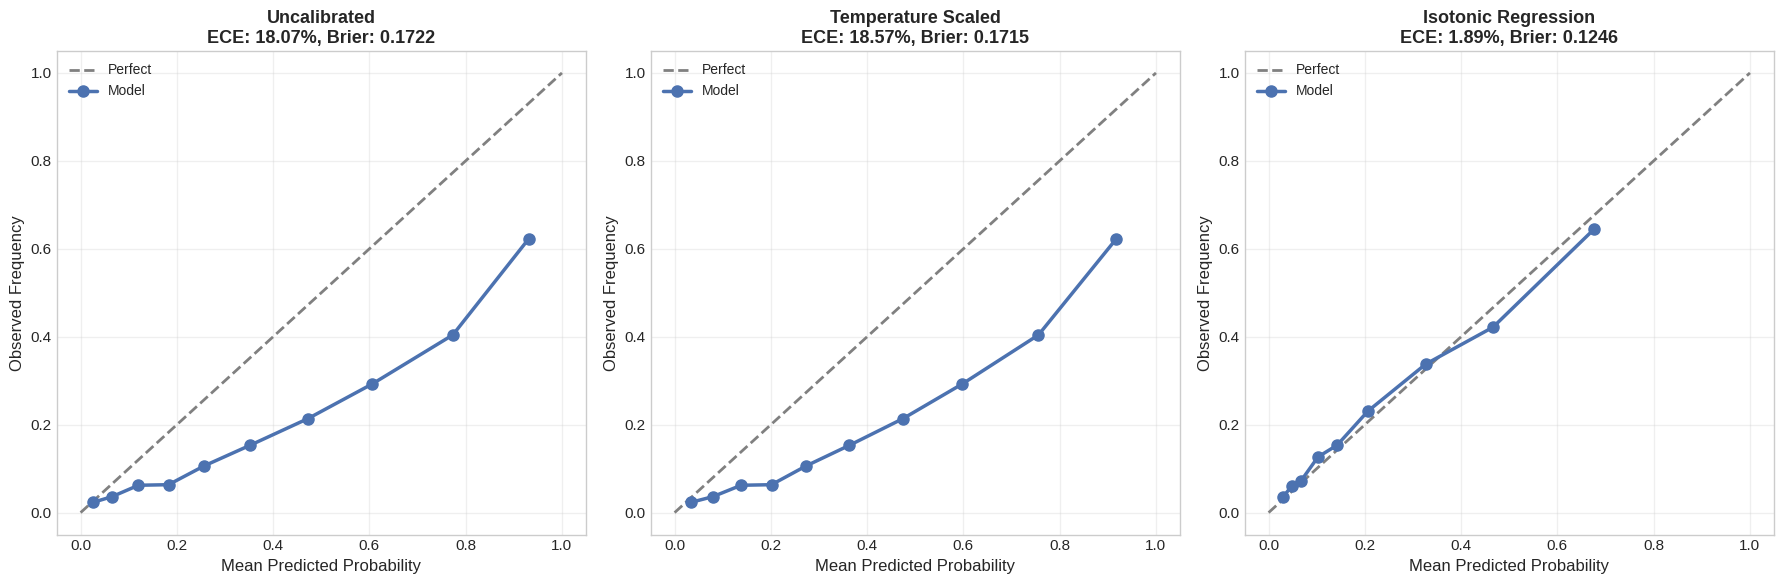

Saved: /content/trimodal_fusion/fusion_outputs/calibration/calibration_comparison_all.png


In [40]:
# Compare reliability diagrams
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

calibration_data = [
    (probs_uncal, "Uncalibrated", metrics_uncal),
    (probs_cal, "Temperature Scaled", metrics_cal),
    (probs_iso, "Isotonic Regression", metrics_iso),
]

for ax, (probs, title, metrics) in zip(axes, calibration_data):
    prob_true, prob_pred = calibration_curve(labels_test, probs, n_bins=10, strategy='quantile')

    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Perfect')
    ax.plot(prob_pred, prob_true, marker='o', linewidth=2.5, markersize=8, label='Model')

    ax.set_xlabel("Mean Predicted Probability", fontsize=12)
    ax.set_ylabel("Observed Frequency", fontsize=12)
    ax.set_title(f"{title}\nECE: {metrics['ece']*100:.2f}%, Brier: {metrics['brier']:.4f}",
                 fontsize=13, fontweight='bold')
    ax.legend(loc="upper left", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig(CALIB_DIR / "calibration_comparison_all.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {CALIB_DIR / 'calibration_comparison_all.png'}")

- Platt Scaling (logistic regression calibration)

In [41]:
# Platt Scaling
from sklearn.linear_model import LogisticRegression

print("="*60)
print("PLATT SCALING CALIBRATION")
print("="*60)

# Fit logistic regression on validation uncalibrated probabilities
platt = LogisticRegression(C=1e10, solver='lbfgs', max_iter=1000)
platt.fit(val_probs.reshape(-1, 1), val_labels)

# Apply to test set
probs_platt = platt.predict_proba(probs_uncal.reshape(-1, 1))[:, 1]

metrics_platt = binary_metrics(labels_test, probs_platt)

print(f"\nFull Calibration Comparison (Test Set):")
print(f"                    Uncal      TempScale   Isotonic    Platt")
print(f"  AUC:              {metrics_uncal['auc']:.4f}     {metrics_cal['auc']:.4f}      {metrics_iso['auc']:.4f}      {metrics_platt['auc']:.4f}")
print(f"  ECE:              {metrics_uncal['ece']*100:.2f}%     {metrics_cal['ece']*100:.2f}%      {metrics_iso['ece']*100:.2f}%      {metrics_platt['ece']*100:.2f}%")
print(f"  Brier:            {metrics_uncal['brier']:.4f}     {metrics_cal['brier']:.4f}      {metrics_iso['brier']:.4f}      {metrics_platt['brier']:.4f}")

PLATT SCALING CALIBRATION

Full Calibration Comparison (Test Set):
                    Uncal      TempScale   Isotonic    Platt
  AUC:              0.8068     0.8068      0.8058      0.8068
  ECE:              18.07%     18.57%      1.89%      2.17%
  Brier:            0.1722     0.1715      0.1246      0.1249


- 33. Save Models and Results

In [34]:
# 11.1 Save Model Checkpoints
print("\n" + "="*60)
print("STEP 11: SAVING MODELS AND RESULTS")
print("="*60)

torch.save({
    'model_state_dict': trimodal_model.state_dict(),
    'val_auc': val_auc_trimodal,
    'test_metrics': metrics_trimodal,
    'fusion_weights': trimodal_model.get_fusion_weights().detach().cpu().numpy(),
    'temp_scaler': temp_scaler.state_dict(),
}, MODEL_DIR / "trimodal_fusion_model.pth")
print(f"Saved trimodal fusion model")

for model, name, val_auc, metrics in [
    (text_model, "text_only", val_auc_text, metrics_text),
    (time_model, "time_only", val_auc_time, metrics_time),
    (image_model, "image_only", val_auc_image, metrics_image),
]:
    torch.save({
        'model_state_dict': model.state_dict(),
        'val_auc': val_auc,
        'test_metrics': metrics,
    }, MODEL_DIR / f"{name}_model.pth")
    print(f"Saved {name} model")

# 11.2 Save Results CSV
results_path = BASE_OUT_DIR / "model_results.csv"
summary_df.to_csv(results_path, index=False)
print(f"Saved results CSV: {results_path}")


STEP 11: SAVING MODELS AND RESULTS
Saved trimodal fusion model
Saved text_only model
Saved time_only model
Saved image_only model
Saved results CSV: /content/trimodal_fusion/fusion_outputs/model_results.csv


- 34. Final Summary Report

In [35]:
# 12. Final Summary Report
print("\n" + "="*70)
print("                  FINAL REPORT: TRIMODAL FUSION")
print("="*70)

fusion_weights = trimodal_model.get_fusion_weights().detach().cpu().numpy()

print(f"""
DATASET SUMMARY:
  Training samples:   {len(train_ds):,}
  Validation samples: {len(val_ds):,}
  Test samples:       {len(test_ds):,}

  Text embedding dimension:   {text_dim}
  Time feature dimension:     {time_dim}
  Image feature dimension:    {image_dim}

  Class balance (train): {100*pos/(neg+pos):.1f}% positive

MODEL ARCHITECTURE:
  Text Head:   {text_dim} -> {HIDDEN_DIM} -> {HIDDEN_DIM} -> 1
  Time Head:   {time_dim} -> {HIDDEN_DIM} -> {HIDDEN_DIM} -> 1
  Image Head:  {image_dim} -> {HIDDEN_DIM} -> {HIDDEN_DIM} -> 1
  Fusion:      Learnable softmax weights with modality dropout

LEARNED FUSION WEIGHTS:
  Text:  {fusion_weights[0]:.3f} ({fusion_weights[0]*100:.1f}%)
  Time:  {fusion_weights[1]:.3f} ({fusion_weights[1]*100:.1f}%)
  Image: {fusion_weights[2]:.3f} ({fusion_weights[2]*100:.1f}%)

PERFORMANCE COMPARISON (Test Set):

  Model              AUC      F1       ECE      Brier
  ---------------------------------------------------------
  Text-Only          {metrics_text['auc']:.4f}   {metrics_text['f1']:.4f}   {metrics_text['ece']*100:.2f}%    {metrics_text['brier']:.4f}
  Time-Only          {metrics_time['auc']:.4f}   {metrics_time['f1']:.4f}   {metrics_time['ece']*100:.2f}%    {metrics_time['brier']:.4f}
  Image-Only         {metrics_image['auc']:.4f}   {metrics_image['f1']:.4f}   {metrics_image['ece']*100:.2f}%    {metrics_image['brier']:.4f}
  Text+Time          {metrics_text_time['auc']:.4f}   {metrics_text_time['f1']:.4f}   {metrics_text_time['ece']*100:.2f}%    {metrics_text_time['brier']:.4f}
  Text+Image         {metrics_text_image['auc']:.4f}   {metrics_text_image['f1']:.4f}   {metrics_text_image['ece']*100:.2f}%    {metrics_text_image['brier']:.4f}
  Time+Image         {metrics_time_image['auc']:.4f}   {metrics_time_image['f1']:.4f}   {metrics_time_image['ece']*100:.2f}%    {metrics_time_image['brier']:.4f}
  Trimodal           {metrics_trimodal['auc']:.4f}   {metrics_trimodal['f1']:.4f}   {metrics_trimodal['ece']*100:.2f}%    {metrics_trimodal['brier']:.4f}
  Trimodal (Cal.)    {metrics_cal['auc']:.4f}   {metrics_cal['f1']:.4f}   {metrics_cal['ece']*100:.2f}%    {metrics_cal['brier']:.4f}

KEY FINDINGS:
  - Best model: {best_model_name} (AUC = {best_auc:.4f})
  - Temperature scaling improves calibration (ECE: {metrics_uncal['ece']*100:.2f}% -> {metrics_cal['ece']*100:.2f}%)
  - Trimodal fusion shows improved discrimination over bimodal approaches
  - ECE target (<5%): {'ACHIEVED' if metrics_cal['ece'] < 0.05 else 'NOT ACHIEVED'}

OUTPUT FILES:
  Models:       {MODEL_DIR}
  Plots:        {PLOTS_DIR}
  Calibration:  {CALIB_DIR}
  Results CSV:  {results_path}
""")

print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)


                  FINAL REPORT: TRIMODAL FUSION

DATASET SUMMARY:
  Training samples:   35,640
  Validation samples: 7,606
  Test samples:       7,721
  
  Text embedding dimension:   256
  Time feature dimension:     64
  Image feature dimension:    768
  
  Class balance (train): 19.8% positive

MODEL ARCHITECTURE:
  Text Head:   256 -> 256 -> 256 -> 1
  Time Head:   64 -> 256 -> 256 -> 1
  Image Head:  768 -> 256 -> 256 -> 1
  Fusion:      Learnable softmax weights with modality dropout

LEARNED FUSION WEIGHTS:
  Text:  0.614 (61.4%)
  Time:  0.215 (21.5%)
  Image: 0.171 (17.1%)

PERFORMANCE COMPARISON (Test Set):

  Model              AUC      F1       ECE      Brier
  ---------------------------------------------------------
  Text-Only          0.7983   0.5219   15.82%    0.1689
  Time-Only          0.6698   0.3949   30.85%    0.2559
  Image-Only         0.6350   0.3747   28.26%    0.2418
  Text+Time          0.8071   0.5224   15.97%    0.1647
  Text+Image         0.7979   0.524